In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras.constraints import max_norm
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

from technicalSignals import momentum,SMA,inBBands





#CPU RUN
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/simone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
# TREND_WINDOWs = [(1,29)]
# kind_of_dataset = 'AffectiveSpace'
# NN_INPUT_DIM = 716
TREND_WINDOWs = [(1,50)]
kind_of_dataset = 'Summary'
NN_INPUT_DIM = 65

In [3]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = momentum(price, 30)
            price['mom_50'] = momentum(price, 50)
            price['mom_100'] = momentum(price, 100)
            price['mom_150'] = momentum(price, 150)
            price['SMA_30'] = SMA(price, 30)
            price['SMA_50'] = SMA(price, 50)
            price['SMA_100'] = SMA(price, 100)
            price['SMA_150'] = SMA(price, 150)
            price['in_BBands'] = inBBands(price)

        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 20, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150','SMA_30','SMA_50','SMA_100','SMA_150','in_BBands']
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(cumulative_return)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])
        
        y = self.normalize(np.array(y))
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    
    def normalize(self, values):
        m = min(values)
        M = max(values)
        values = 2*(values-m)/(M-m)-1
        return values

In [7]:
def buildNN(l2_regularizer,n_units,dropout):
    model = Sequential()  
    model.add(Dense(n_units, input_dim=NN_INPUT_DIM, activity_regularizer=regularizers.l2(l2_regularizer)))
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/2), activity_regularizer=regularizers.l2(l2_regularizer))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/4), activity_regularizer=regularizers.l2(l2_regularizer))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='tanh')) 
    model.compile(optimizer='adam',loss='mse')
    return model

def buildNN2(n_expected_active_units, dropout = 0.5, max_norm_val = 3.0):
    #dropout is the probability of retaining a unit (contrary of paper)
    n_units = math.floor(n_expected_active_units / (1 - dropout))
    model = Sequential()  
    model.add(Dense(n_units, input_dim=NN_INPUT_DIM, kernel_constraint=max_norm(max_norm_val))) #Linear activ. funct Wx+b
    model.add(BatchNormalization()) # Batch norm applied only on the part without activation (done more often)
    model.add(LeakyReLU()) # ReLU can be less sensible to noise? there is an entire area in which the output is 0
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/2), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/4), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='tanh')) 
    model.compile(optimizer='adam',loss='mse')
    return model

def buildNN3(n_expected_active_units, dropout = 0.5, max_norm_val = 3.0):
    #dropout is the probability of retaining a unit (contrary of paper)
    n_units = math.floor(n_expected_active_units * dropout) 
    model = Sequential()  
    model.add(Dense(n_units, input_dim=NN_INPUT_DIM, kernel_constraint=max_norm(max_norm_val))) #Linear activ. funct Wx+b
    model.add(BatchNormalization()) # Batch norm applied only on the part without activation (done more often)
    model.add(LeakyReLU()) # ReLU can be less sensible to noise? there is an entire area in which the output is 0
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/2), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/4), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='tanh')) 
    model.compile(optimizer='adam',loss='mse')
    return model


def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
def plot_hystory(history,y_pred,y_test,l2,drop,n_units):
    f, axarr = plt.subplots(2)
    f.set_figheight(7)
    f.set_figwidth(10)
    axarr[0].plot(y_test,'g', label='y_test')
    axarr[0].plot(y_pred,'r', label='y_pred')
    axarr[1].semilogy(history.history['loss'],'g--',label='loss_train')
    axarr[1].semilogy(history.history['val_loss'],'r--',label='loss_val')
    #axarr[1].set_ylim([0,2])
    axarr[1].legend()   
    axarr[0].legend()   
    axarr[0].set_title('l2: '+str(l2)+' drop: '+str(drop)+' n_units: '+str(n_units))   
    plt.show()
    print('Min val loss: ', min(history.history['val_loss']))
            
            
def cv(x_tv,y_tv):
    l2_space=[0.1,0.05,0.01]
    drop_space=[0.2,0.5,0.7]
    
    max_norm_space=[0.5,1,3,5,10]
    drop_space=[0.5]
    n_unit_space=[4, 8, 16]
    best_mse = float(np.inf)
    best_l2 = 0
    best_drop = 0
    best_n_units = 0
    for l2 in max_norm_space:
        for drop in drop_space:
            for n_units in n_unit_space:
                print('.', end='')
                trainpoint=math.floor(len(x_tv)*0.50)
                dimval=math.floor(trainpoint*0.25)
                endval=trainpoint+dimval
                #Cross validation
                cvMSE = 0
                #nn_model = buildNN(l2_regularizer=l2,n_units=n_units,dropout=drop)
                nn_model = buildNN2(n_expected_active_units=n_units, dropout = drop, max_norm_val = l2)
                for i in range(0,4):
                    x_train=x_tv[0:trainpoint]
                    y_train=y_tv[0:trainpoint]
                    x_val=x_tv[trainpoint:endval]
                    y_val=y_tv[trainpoint:endval]
                    trainpoint=trainpoint+dimval
                    endval=endval+dimval
                    history = nn_model.fit(x_train, y_train, epochs = 300,batch_size =256, verbose=0, 
                                           validation_data=(x_val, y_val),shuffle=True)
                    mse = history.history['val_loss'][-1]
                    y_pred = nn_model.predict(x_val, batch_size=256, verbose=0)
                    cvMSE += mse/4
                    reset_weights(nn_model)
                if(cvMSE < best_mse):
                    best_mse = cvMSE
                    best_l2 = l2
                    best_drop = drop
                    best_n_units = n_units
                plot_hystory(history,y_pred,y_val,l2,drop,n_units)  
                
    return (best_l2,best_drop,best_n_units)




====================  trend:  1   50  ==================== 



AAPL
.

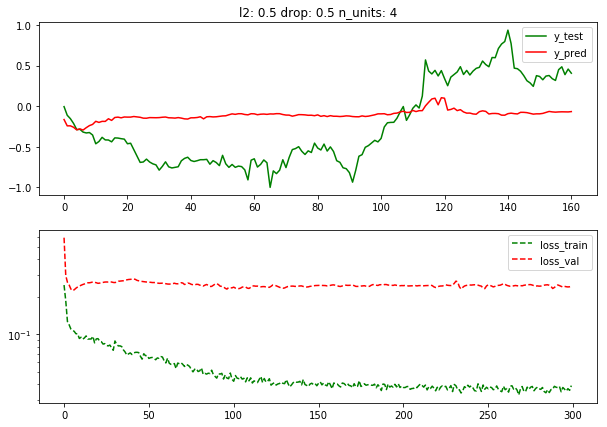

Min val loss:  0.22343677282333374
.

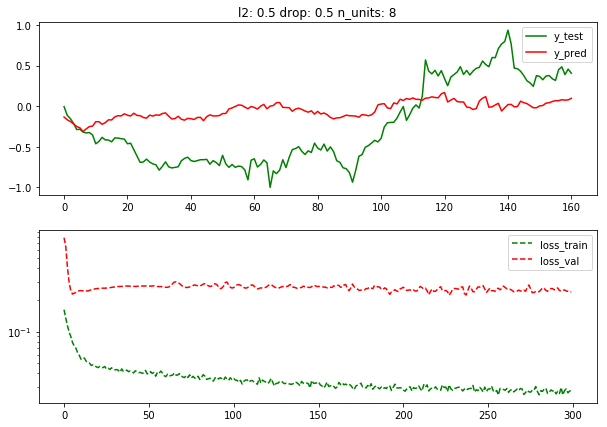

Min val loss:  0.2223609834909439
.

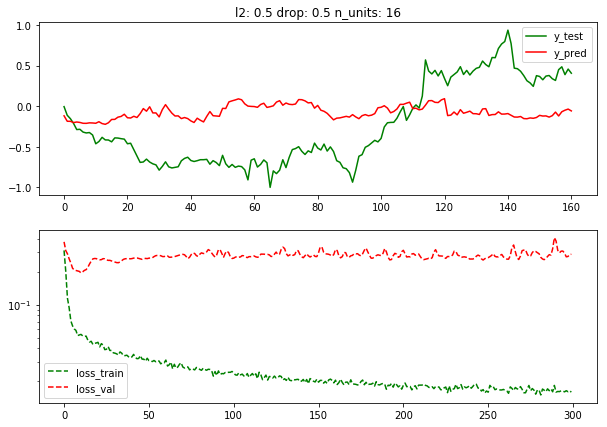

Min val loss:  0.19470350444316864
.

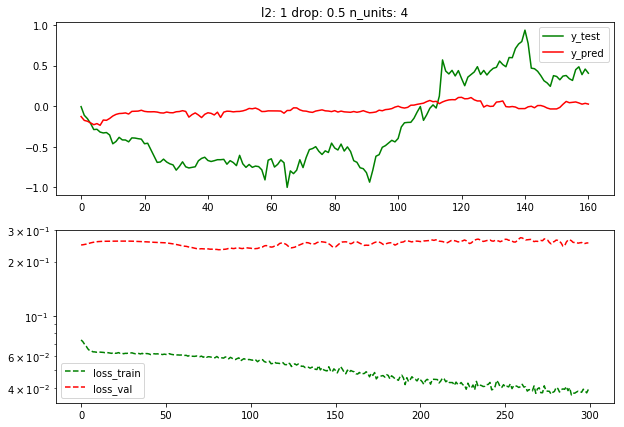

Min val loss:  0.23300059139728546
.

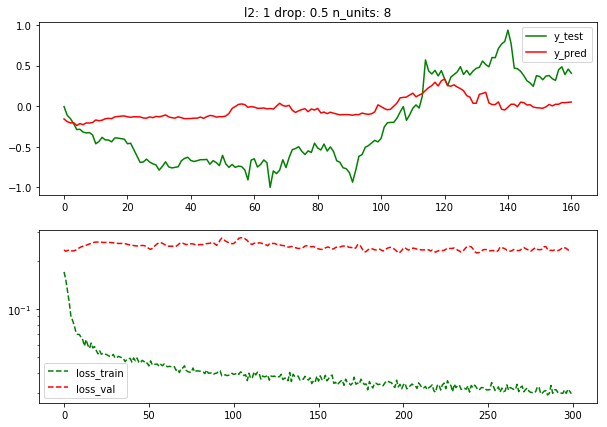

Min val loss:  0.2236788272857666
.

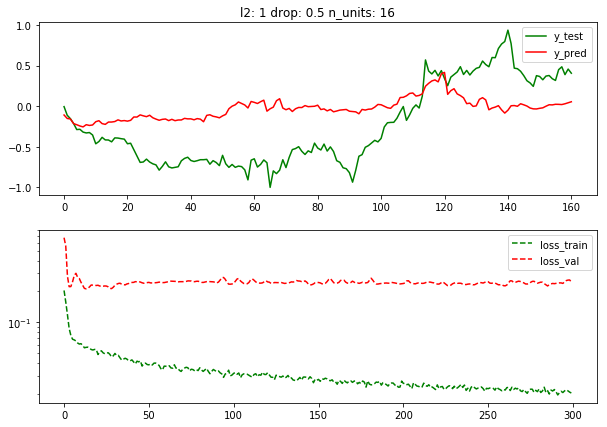

Min val loss:  0.21156378090381622
.

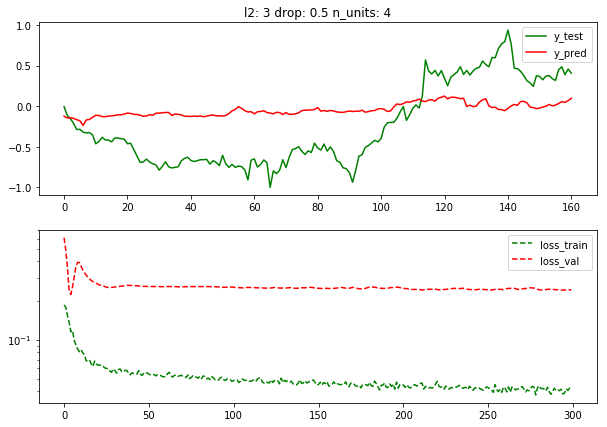

Min val loss:  0.2228604257106781
.

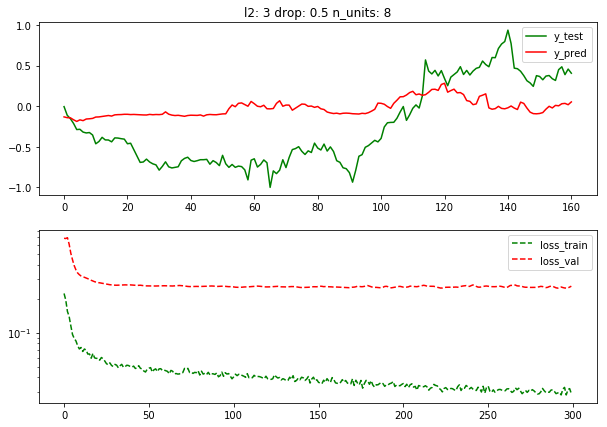

Min val loss:  0.24734345078468323
.

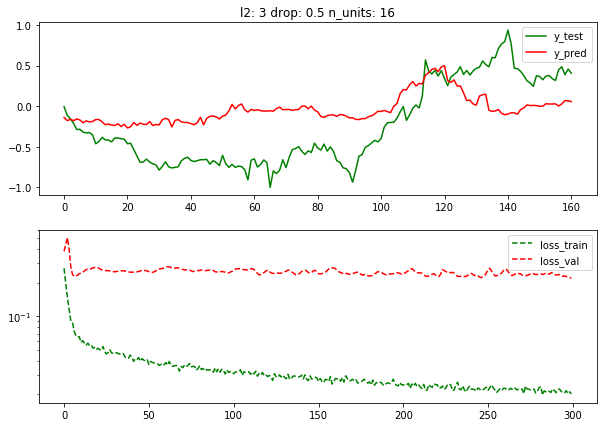

Min val loss:  0.22152110934257507
.

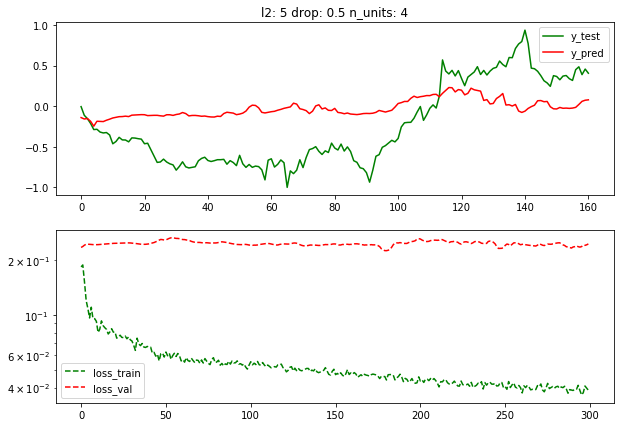

Min val loss:  0.22484545409679413
.

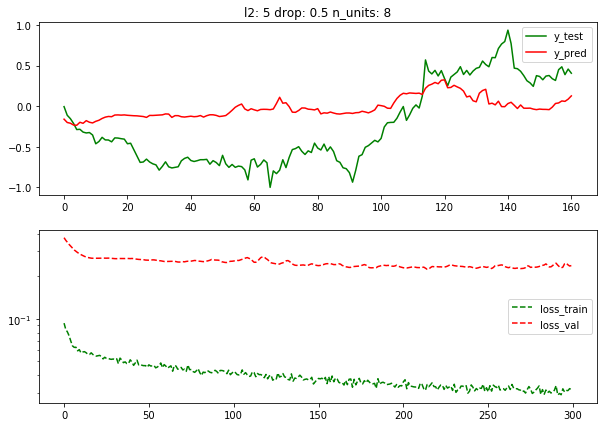

Min val loss:  0.2240118831396103
.

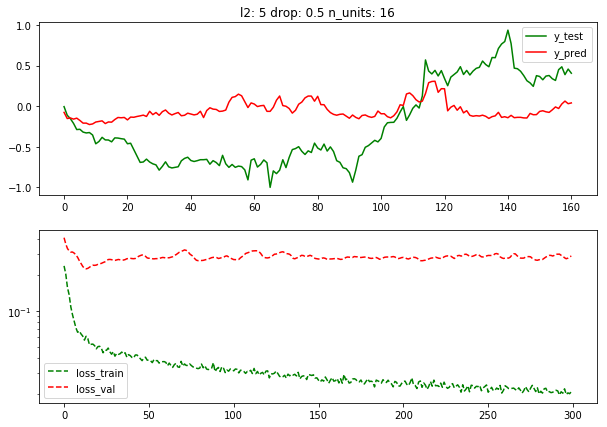

Min val loss:  0.22547462582588196
.

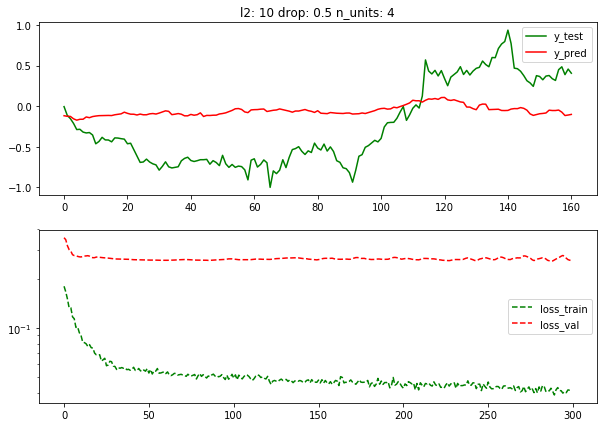

Min val loss:  0.25637128949165344
.

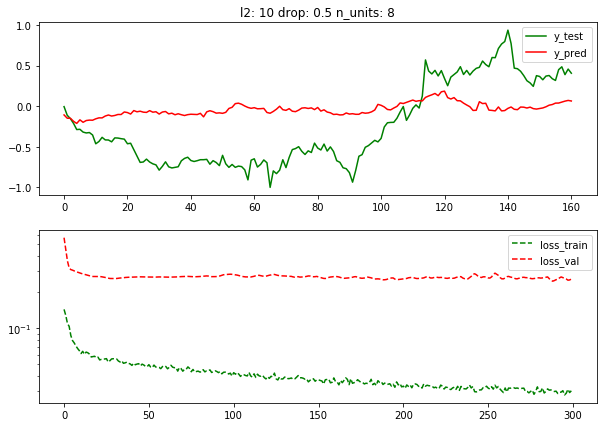

Min val loss:  0.24631673097610474
.

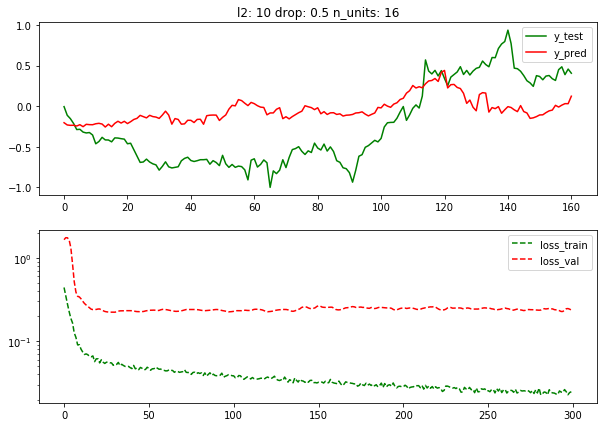

Min val loss:  0.2229461371898651
==== Test ===


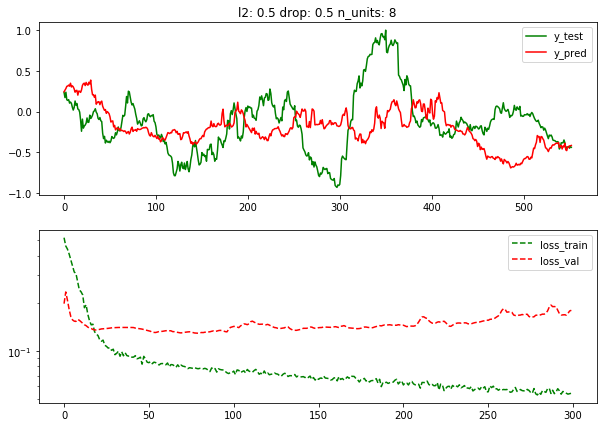

Min val loss:  0.12951312420273345

AMZN
.

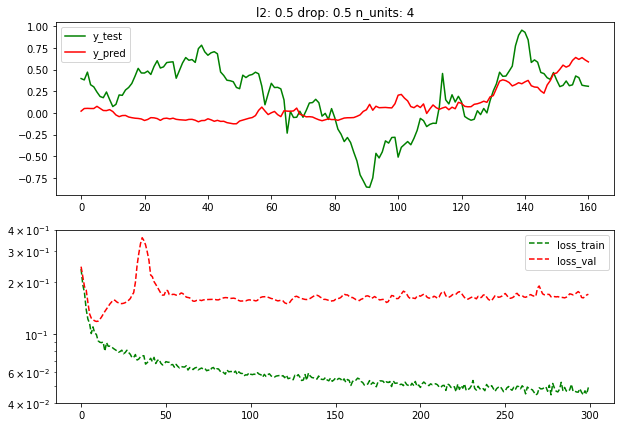

Min val loss:  0.11786029487848282
.

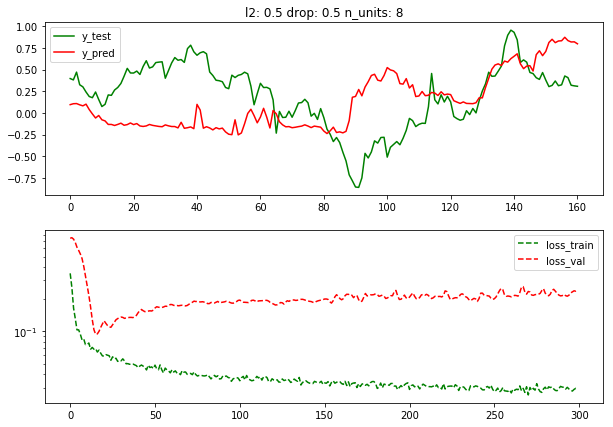

Min val loss:  0.09416425228118896
.

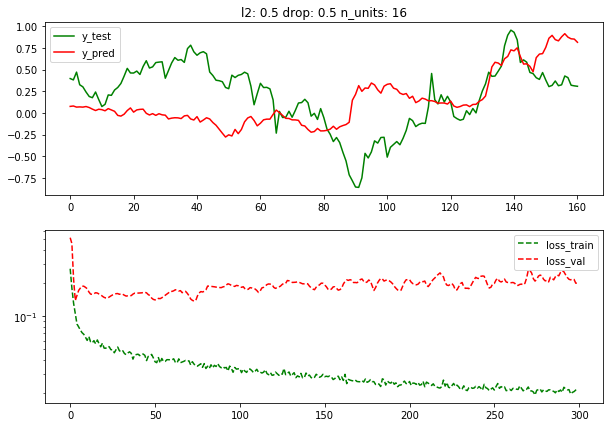

Min val loss:  0.1375553011894226
.

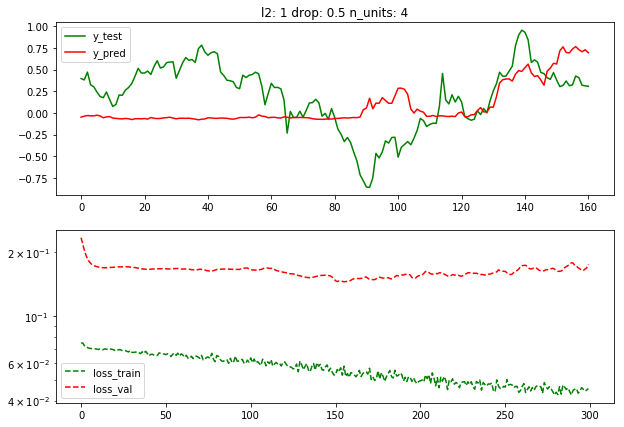

Min val loss:  0.14505882561206818
.

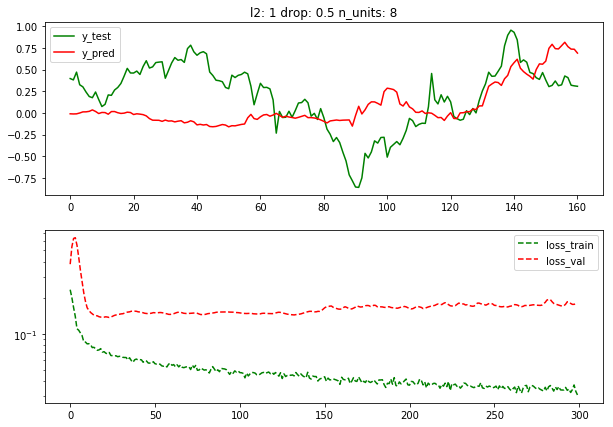

Min val loss:  0.13710054755210876
.

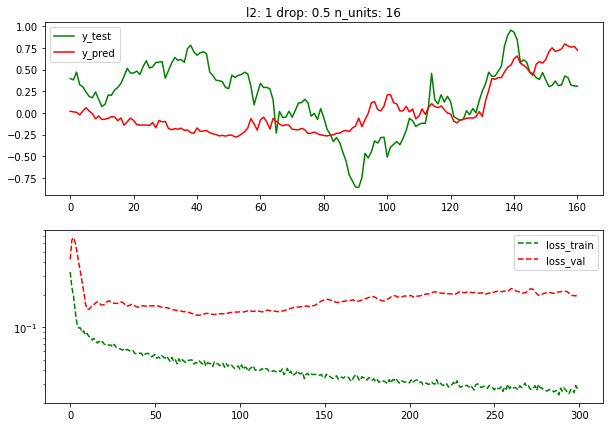

Min val loss:  0.12911410629749298
.

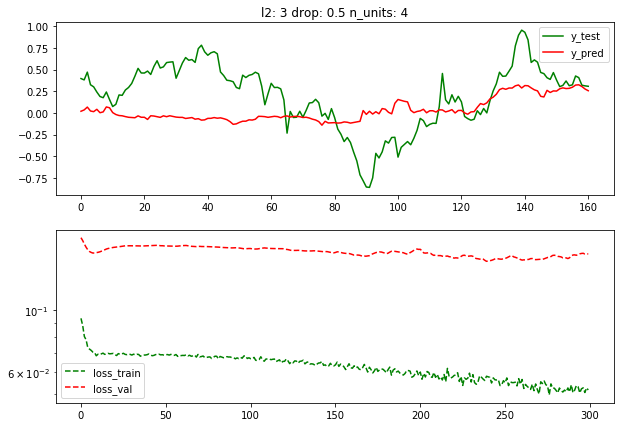

Min val loss:  0.14962555468082428
.

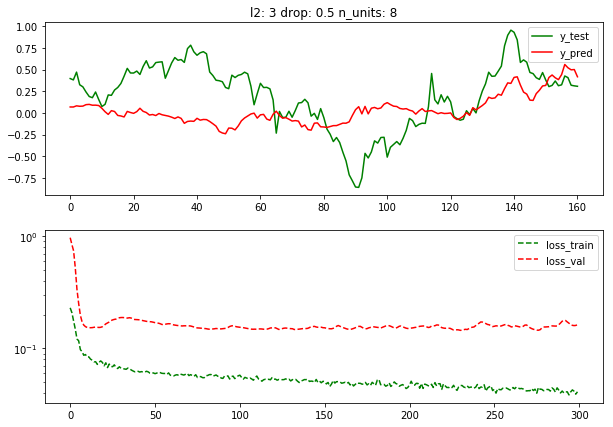

Min val loss:  0.14491257071495056
.

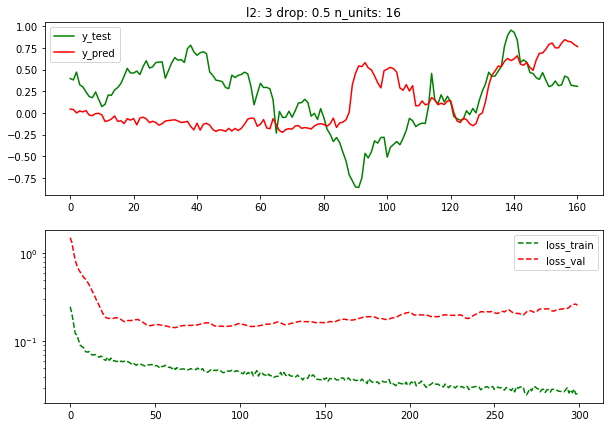

Min val loss:  0.1432831734418869
.

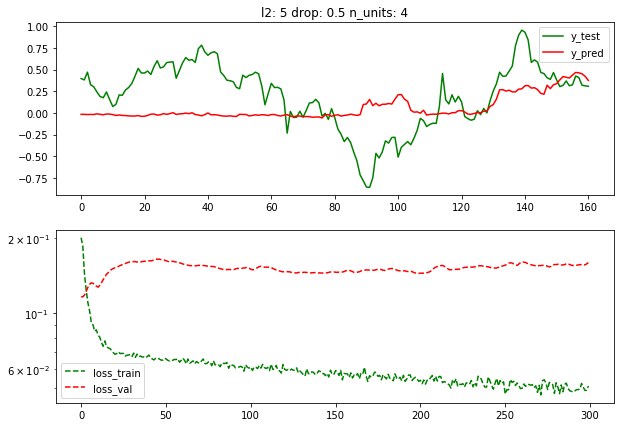

Min val loss:  0.11652381718158722
.

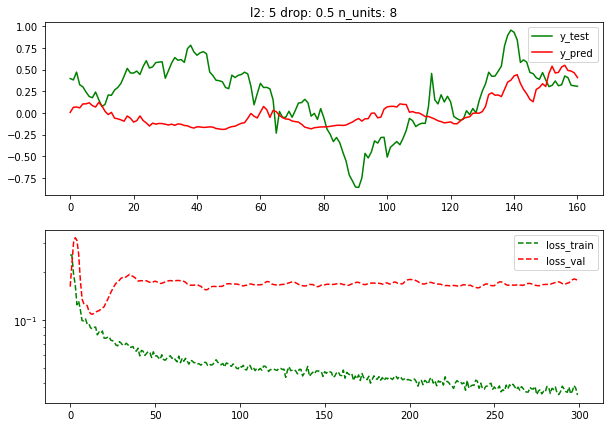

Min val loss:  0.10815546661615372
.

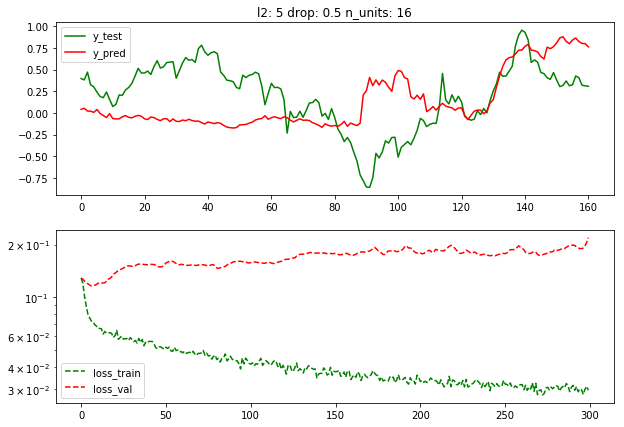

Min val loss:  0.11609605699777603
.

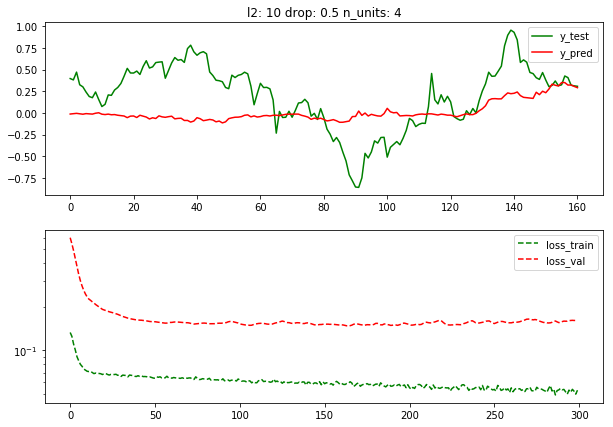

Min val loss:  0.14708098769187927
.

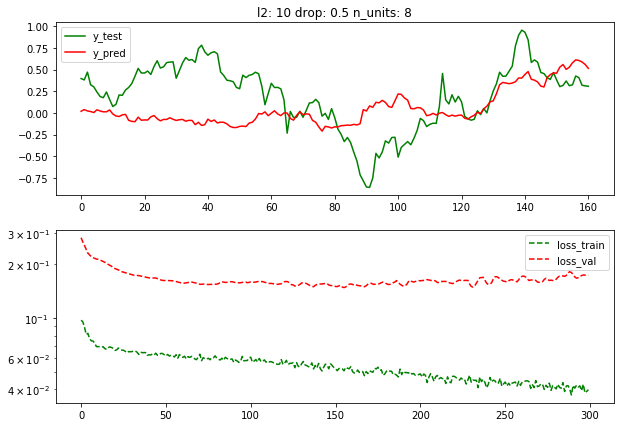

Min val loss:  0.14836664497852325
.

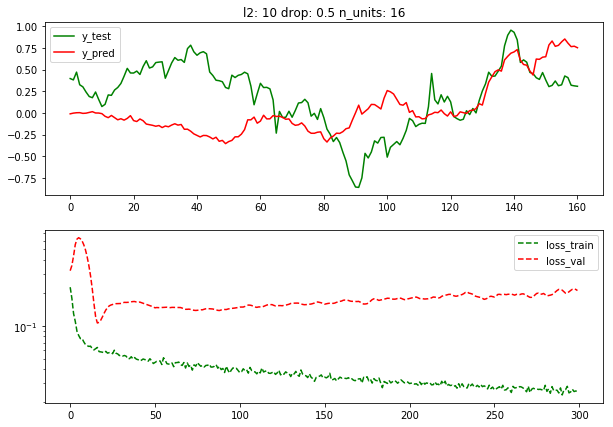

Min val loss:  0.10626985877752304
==== Test ===


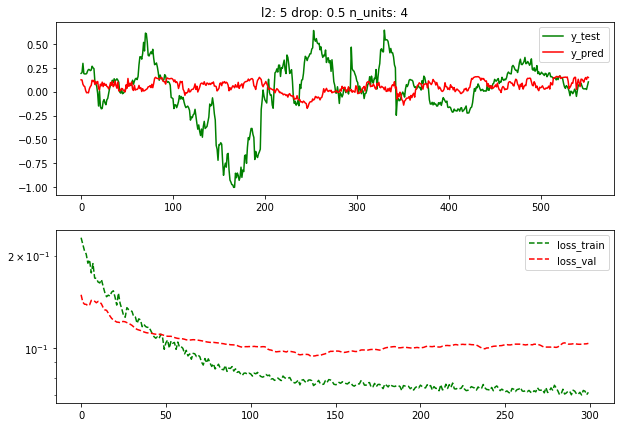

Min val loss:  0.0940744527169313

GOOGL
.

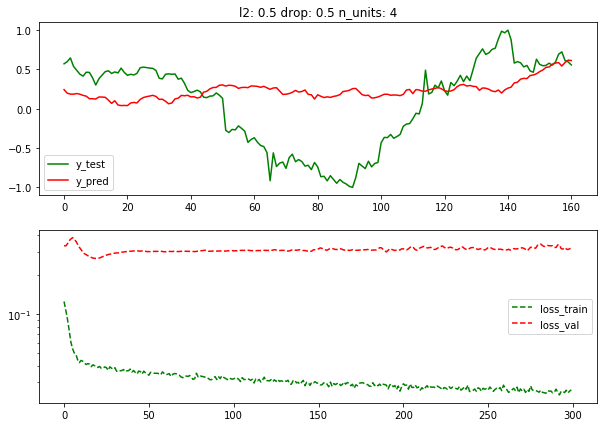

Min val loss:  0.2659796476364136
.

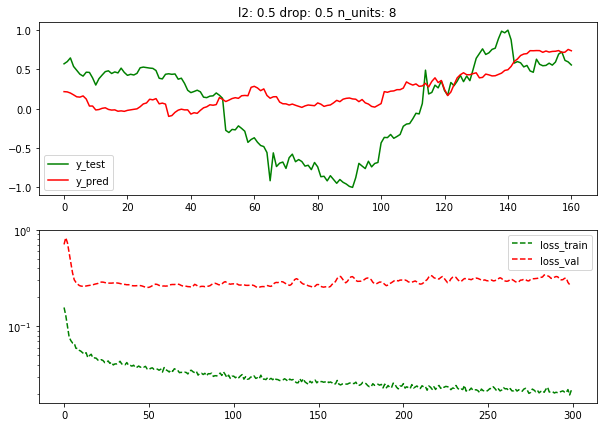

Min val loss:  0.2512761652469635
.

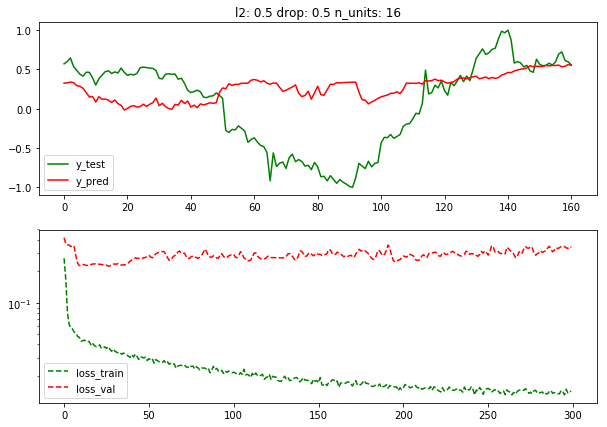

Min val loss:  0.22284157574176788
.

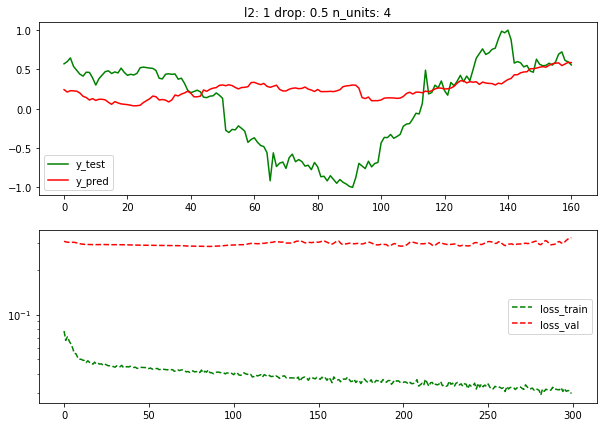

Min val loss:  0.2857774496078491
.

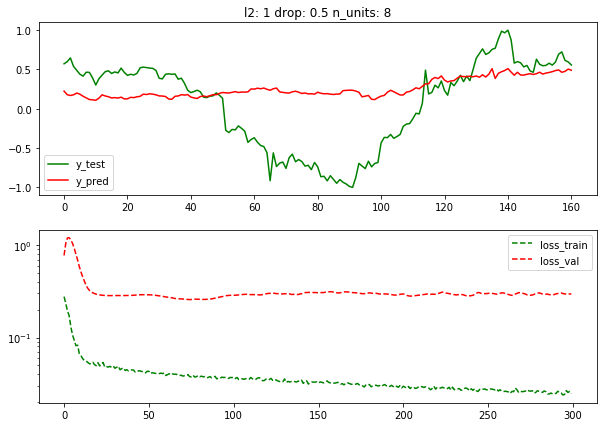

Min val loss:  0.2574230432510376
.

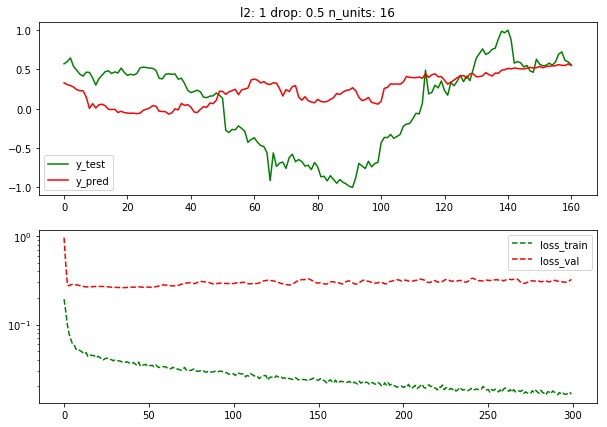

Min val loss:  0.2615048885345459
.

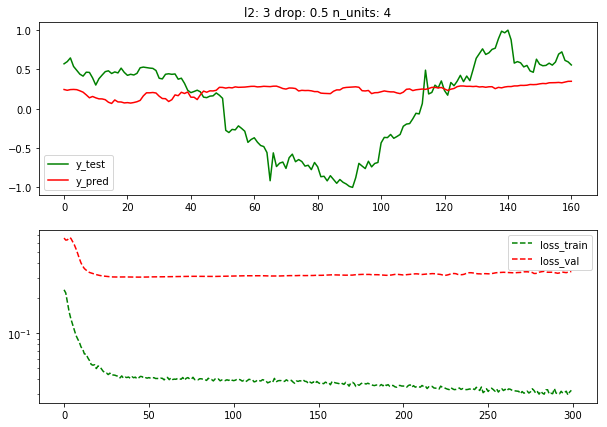

Min val loss:  0.3047559857368469
.

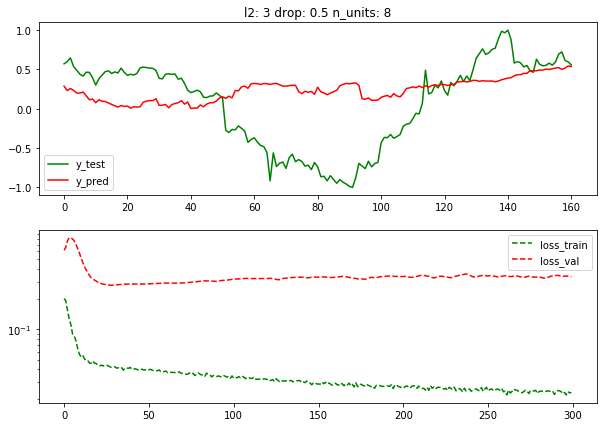

Min val loss:  0.27639469504356384
.

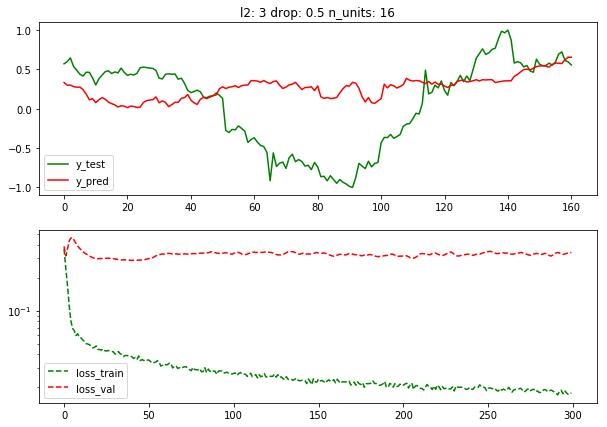

Min val loss:  0.28805670142173767
.

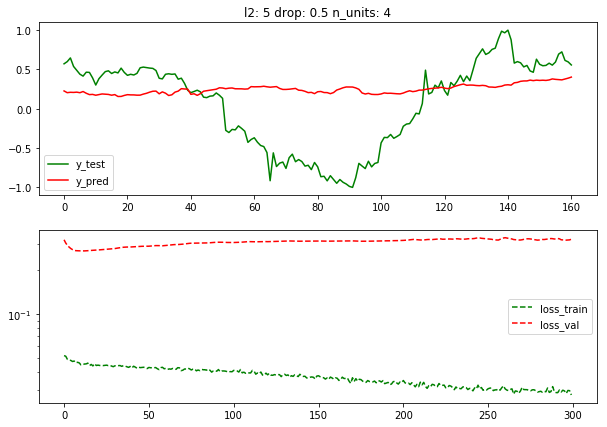

Min val loss:  0.26987960934638977
.

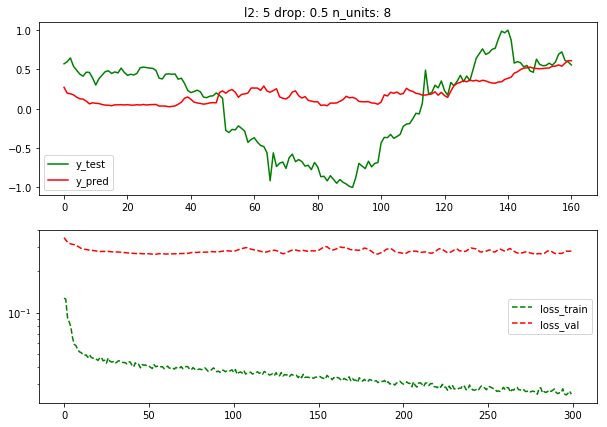

Min val loss:  0.2657777667045593
.

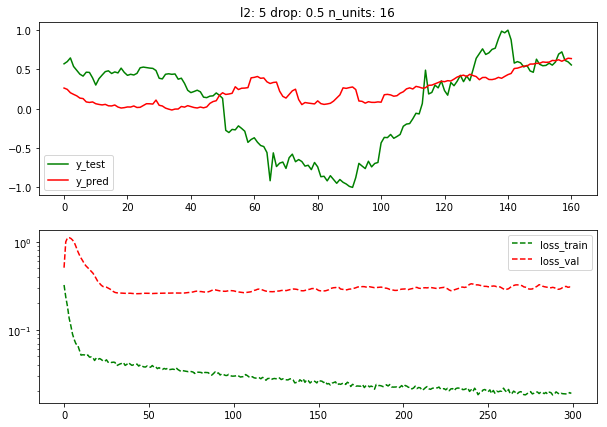

Min val loss:  0.2575460374355316
.

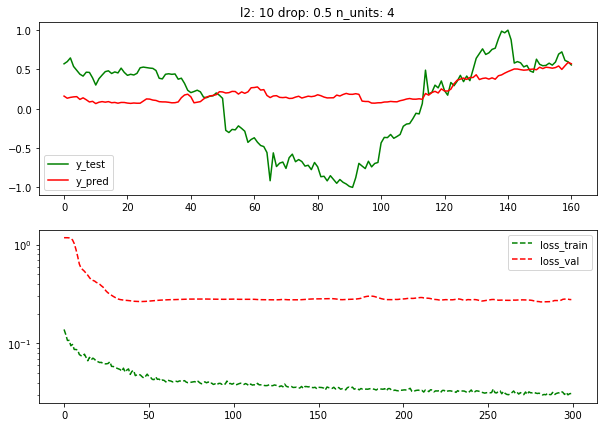

Min val loss:  0.2626635730266571
.

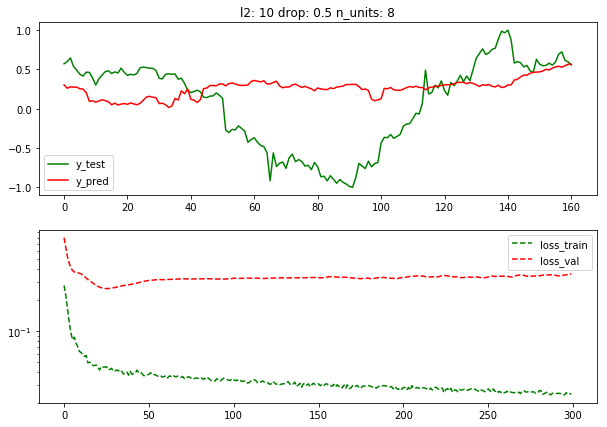

Min val loss:  0.25698867440223694
.

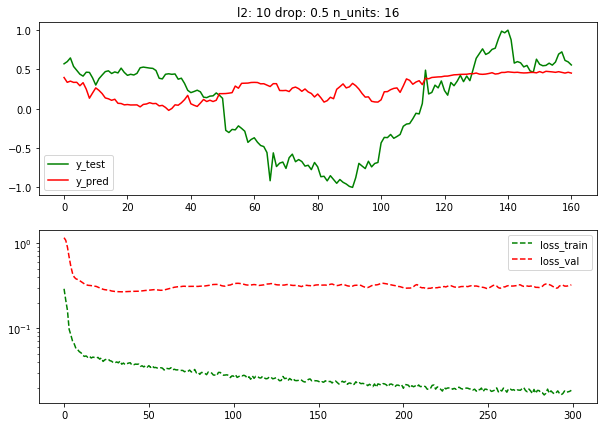

Min val loss:  0.2672378718852997
==== Test ===


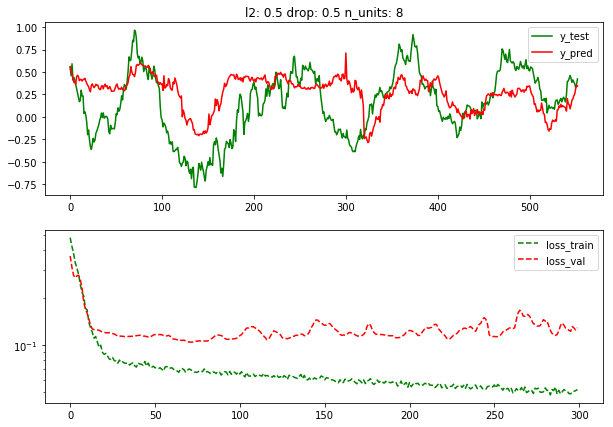

Min val loss:  0.10427533252464496

MSFT
.

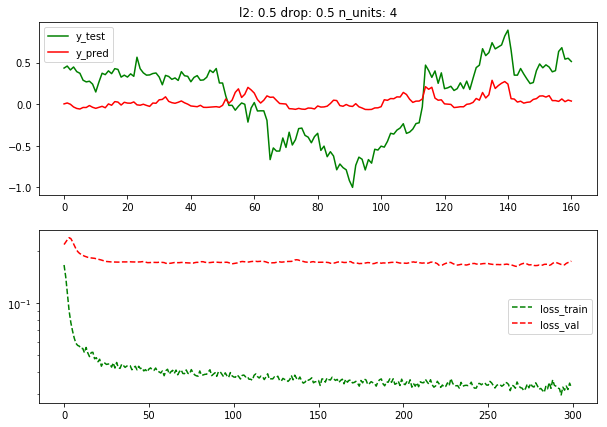

Min val loss:  0.16358697414398193
.

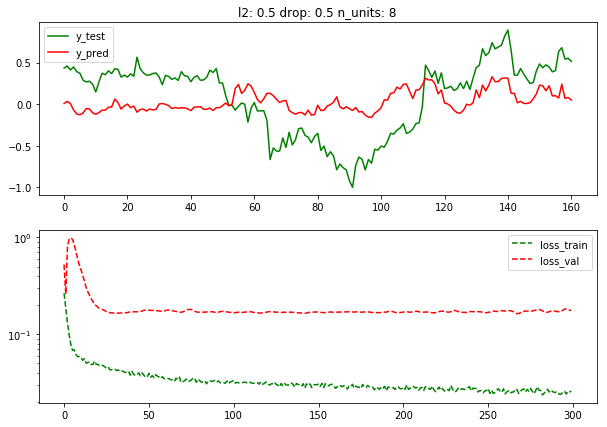

Min val loss:  0.16317705810070038
.

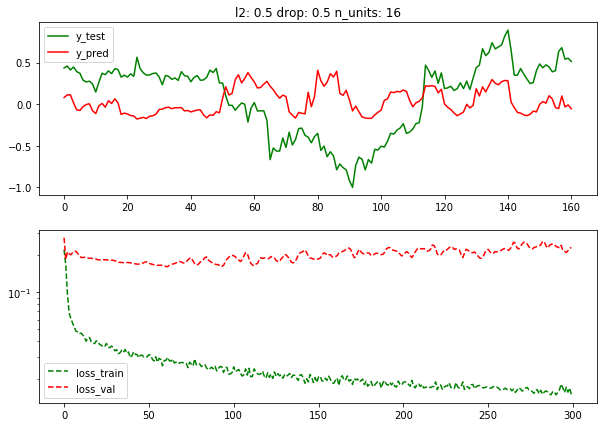

Min val loss:  0.16085784137248993
.

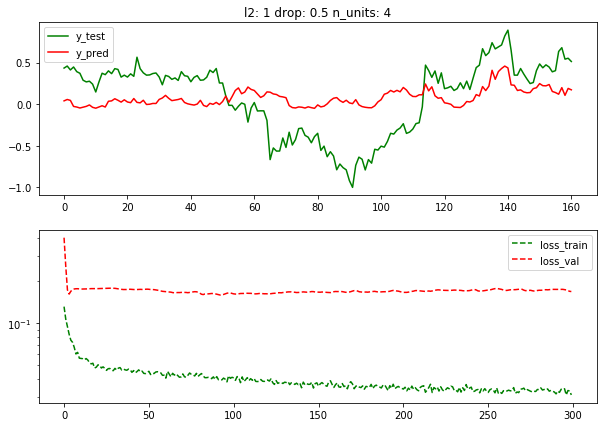

Min val loss:  0.1584368497133255
.

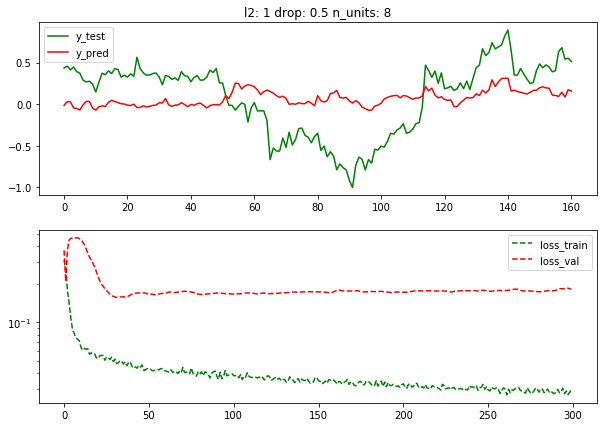

Min val loss:  0.15752921998500824
.

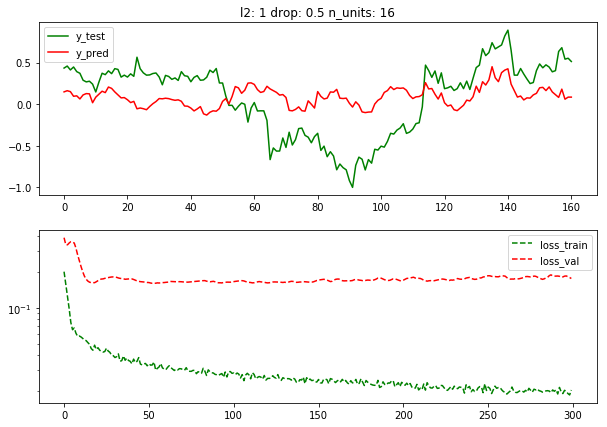

Min val loss:  0.16058869659900665
.

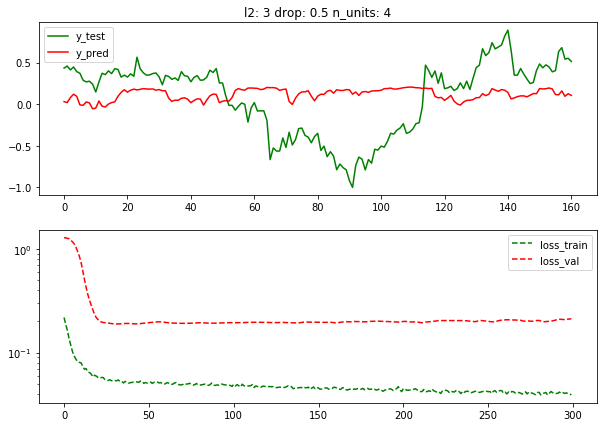

Min val loss:  0.18871591985225677
.

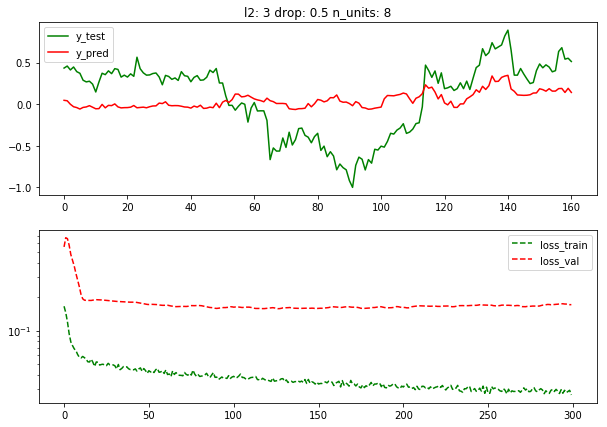

Min val loss:  0.15657341480255127
.

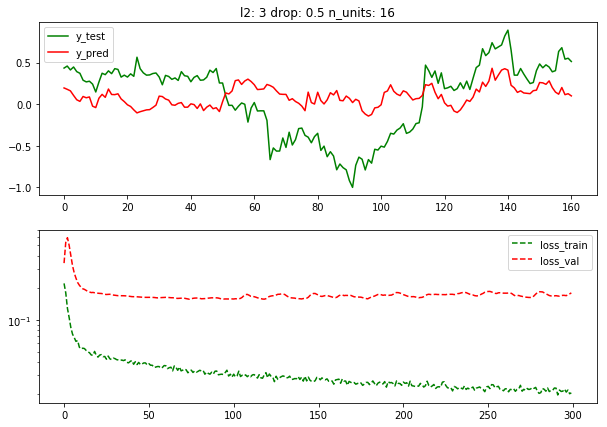

Min val loss:  0.1556967794895172
.

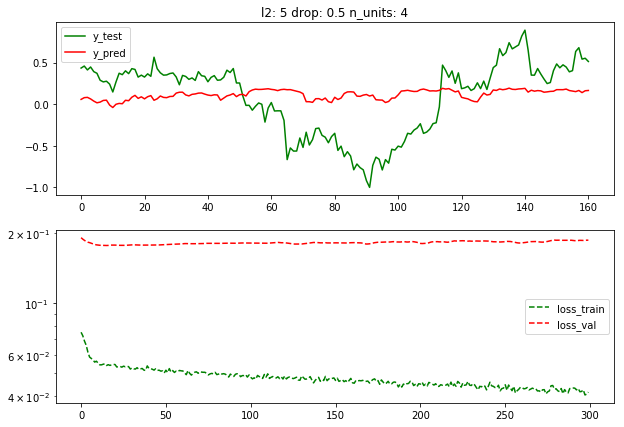

Min val loss:  0.17664867639541626
.

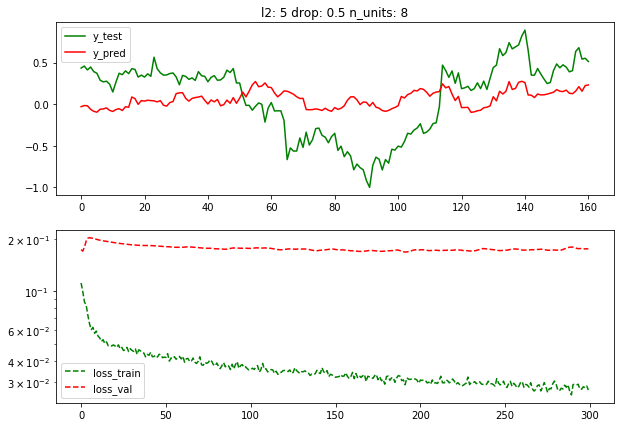

Min val loss:  0.16827799379825592
.

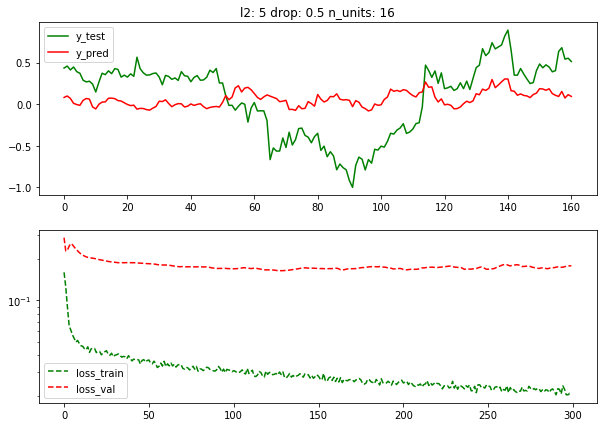

Min val loss:  0.1653592735528946
.

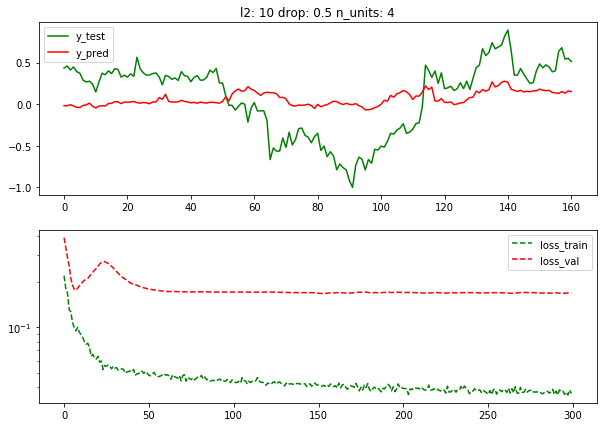

Min val loss:  0.16707545518875122
.

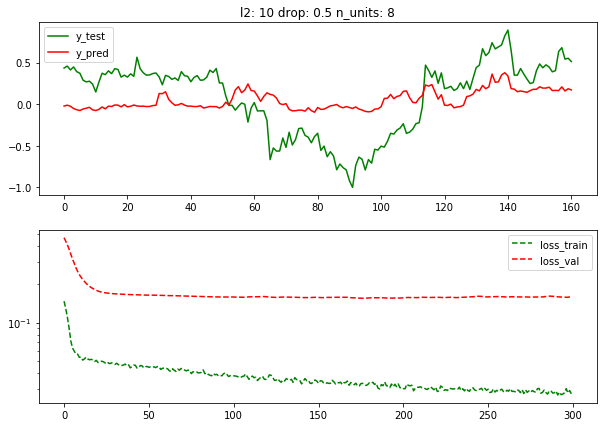

Min val loss:  0.15569865703582764
.

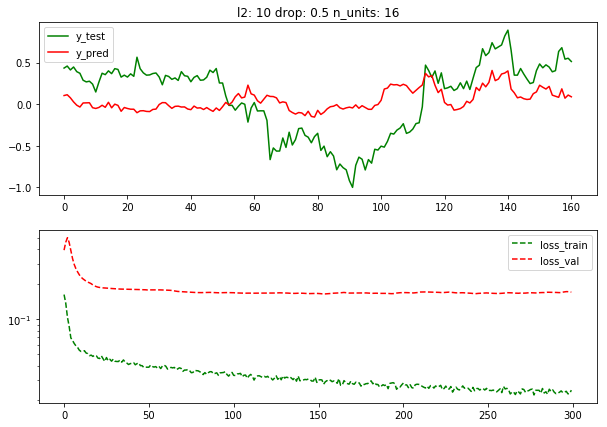

Min val loss:  0.16549551486968994
==== Test ===


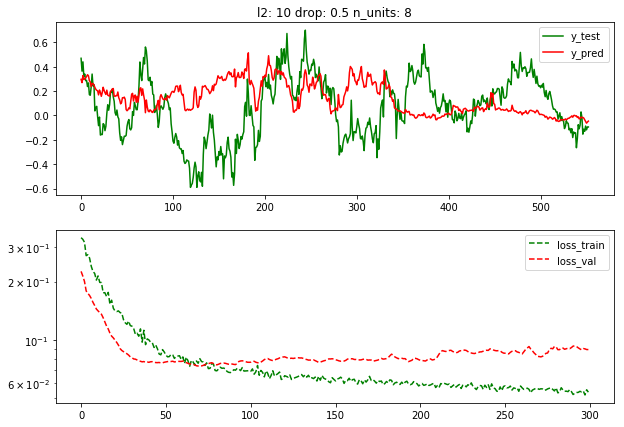

Min val loss:  0.0730561288679945

FB
.

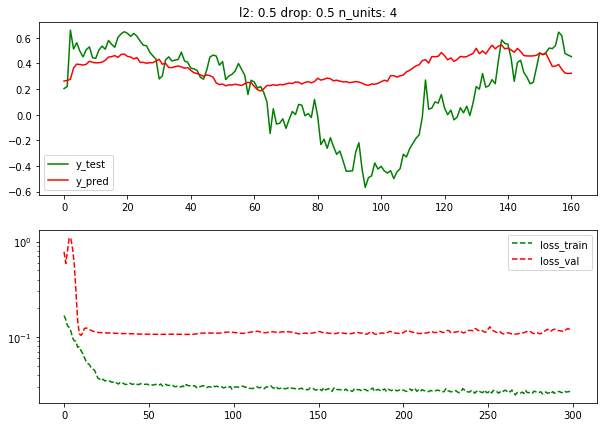

Min val loss:  0.10386618971824646
.

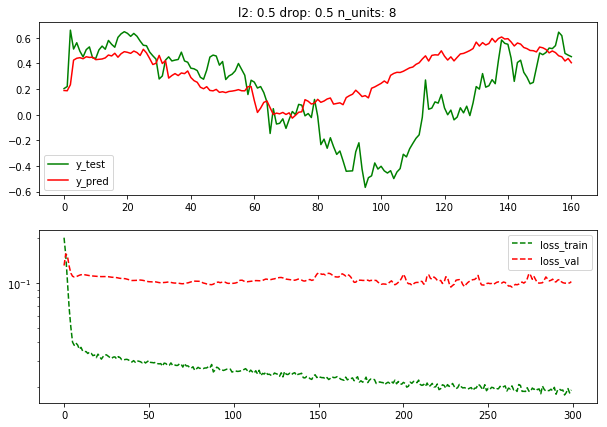

Min val loss:  0.09394742548465729
.

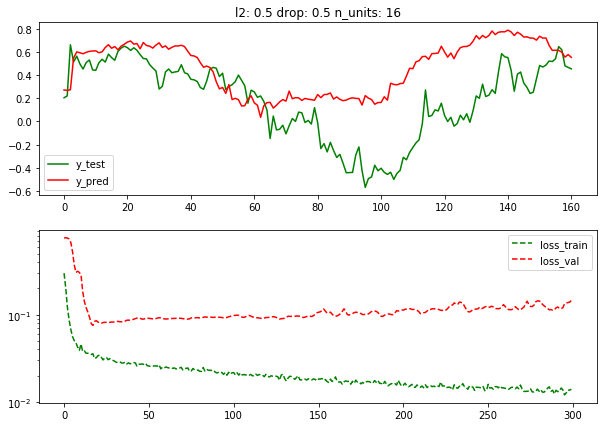

Min val loss:  0.07536870241165161
.

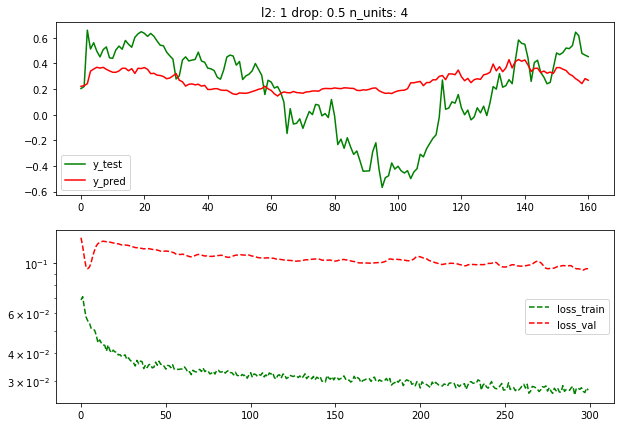

Min val loss:  0.09323079884052277
.

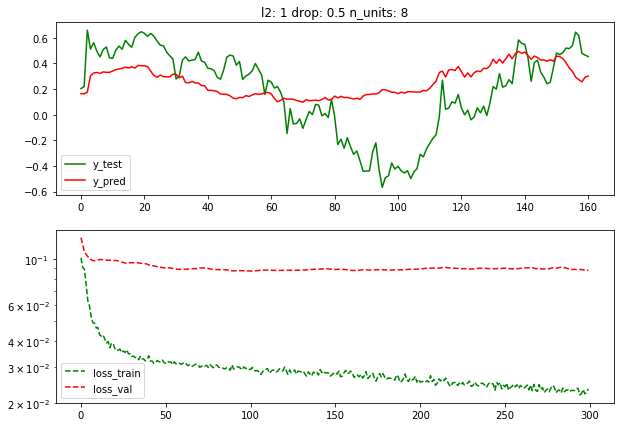

Min val loss:  0.08730300515890121
.

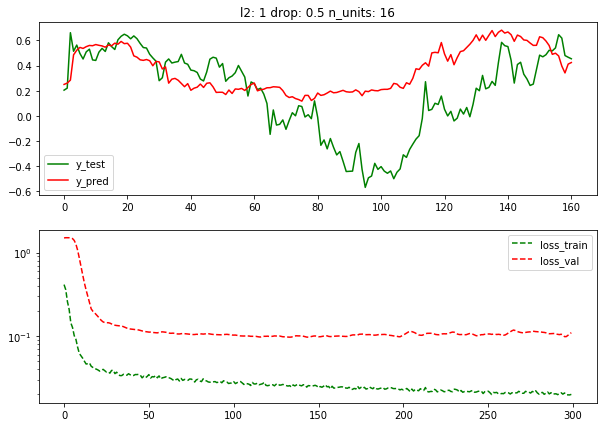

Min val loss:  0.09702210873365402
.

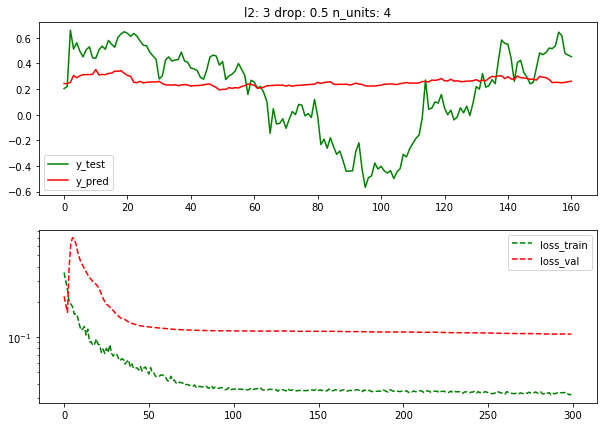

Min val loss:  0.10586301237344742
.

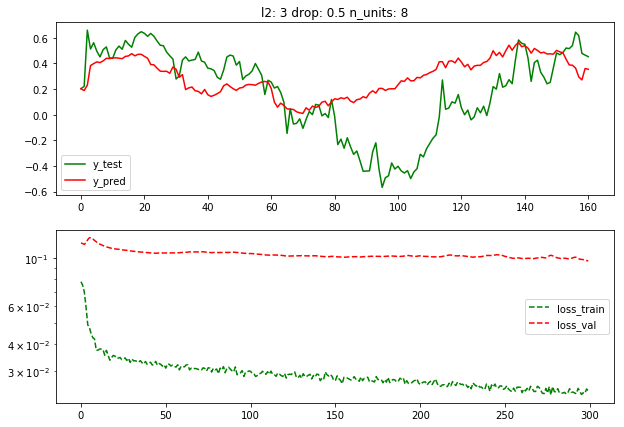

Min val loss:  0.09712868183851242
.

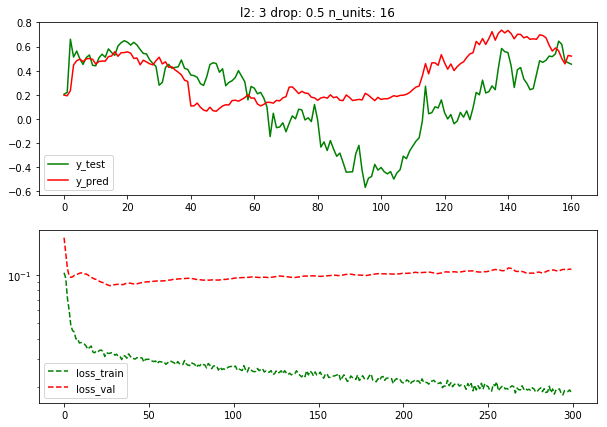

Min val loss:  0.08561016619205475
.

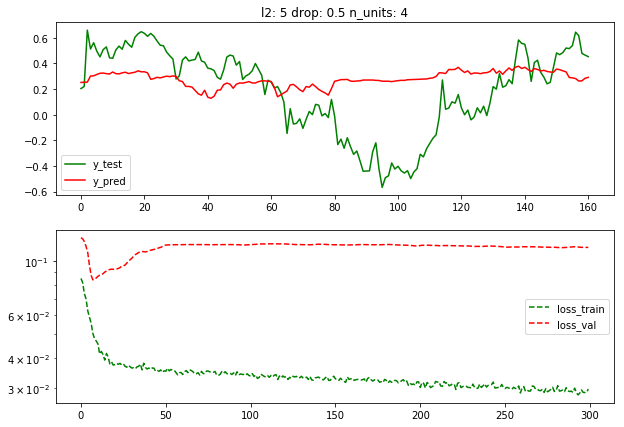

Min val loss:  0.08374395221471786
.

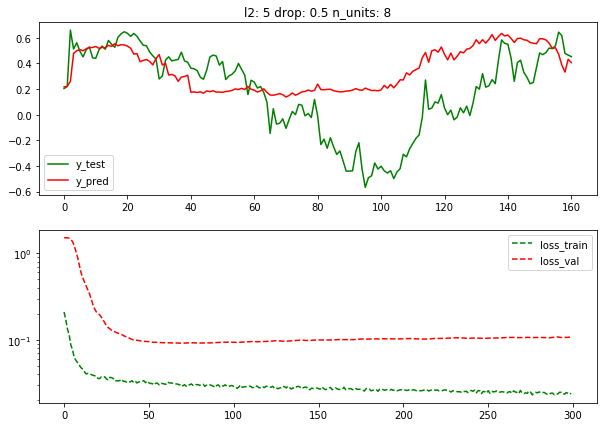

Min val loss:  0.09153774380683899
.

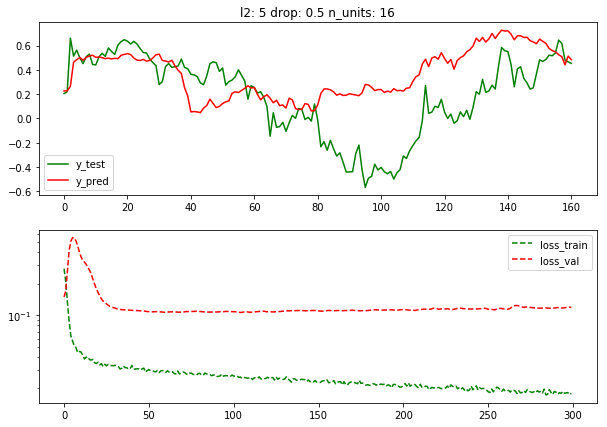

Min val loss:  0.10642153769731522
.

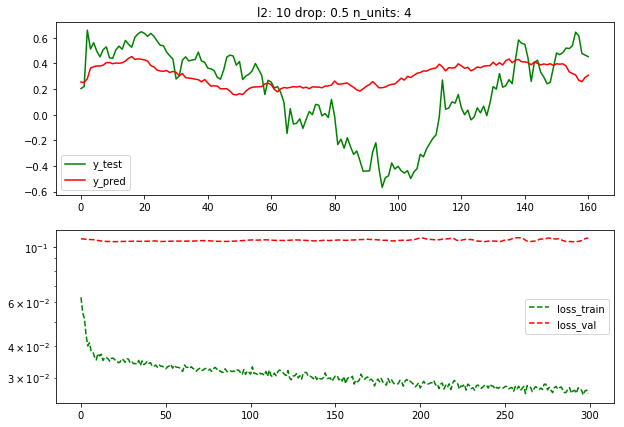

Min val loss:  0.10491050034761429
.

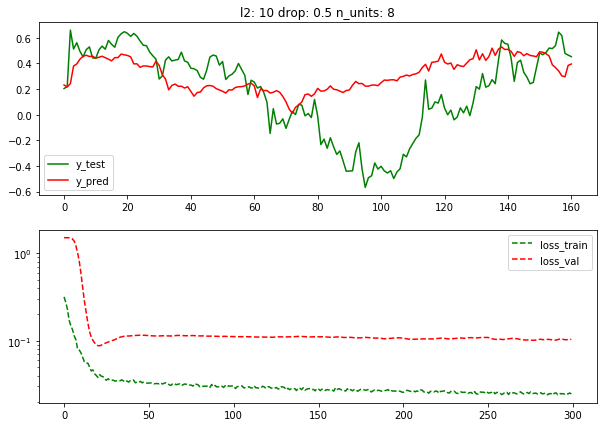

Min val loss:  0.08772165328264236
.

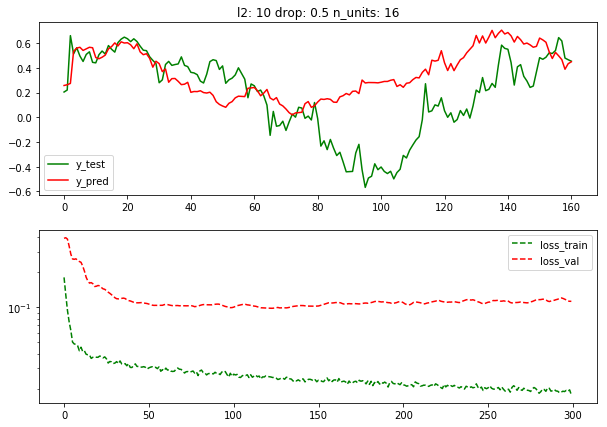

Min val loss:  0.09798683226108551
==== Test ===


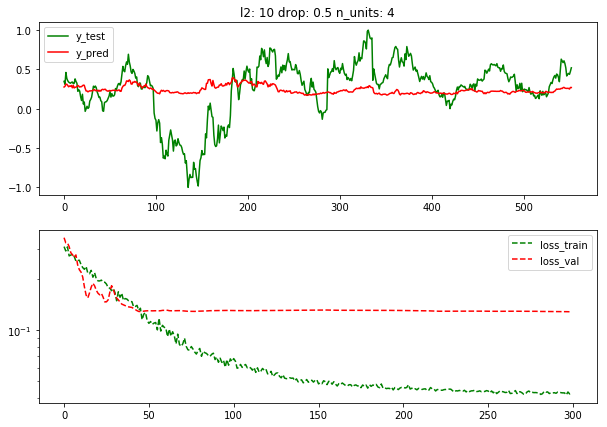

Min val loss:  0.12826782542787776

INTC
.

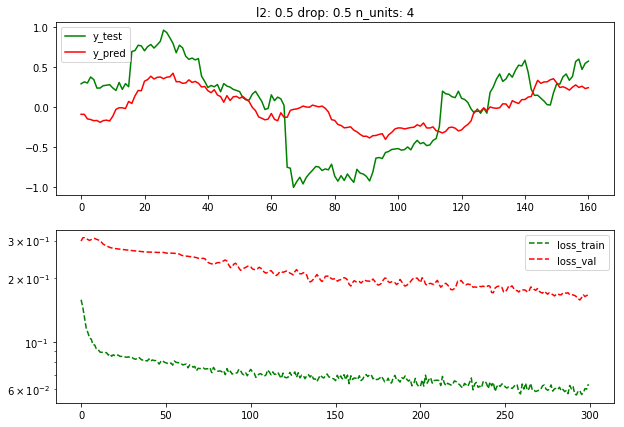

Min val loss:  0.15744420886039734
.

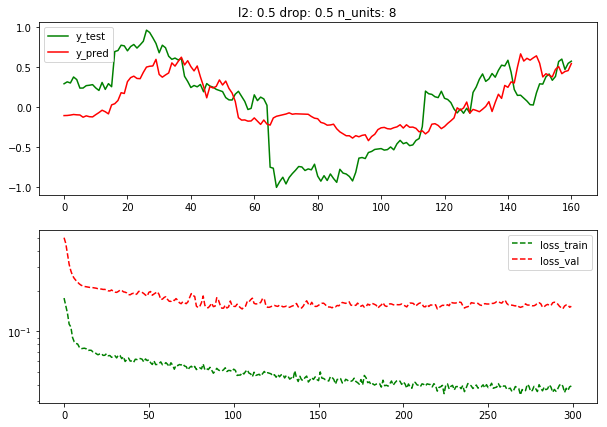

Min val loss:  0.14699256420135498
.

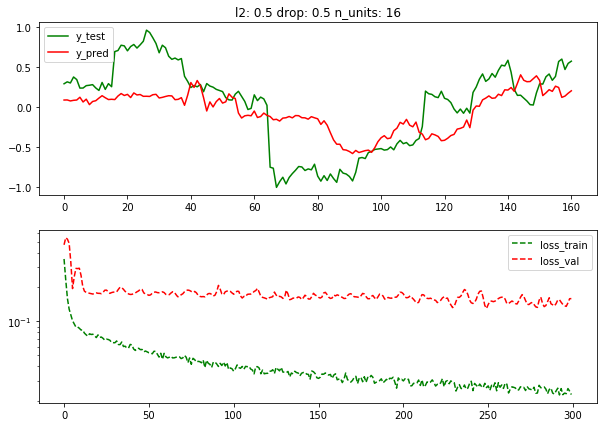

Min val loss:  0.1302240639925003
.

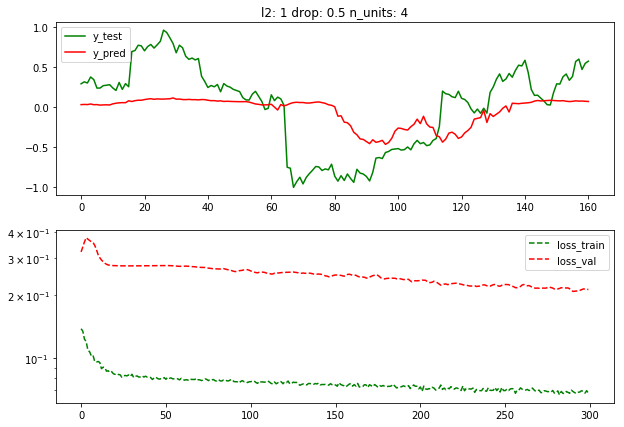

Min val loss:  0.20818030834197998
.

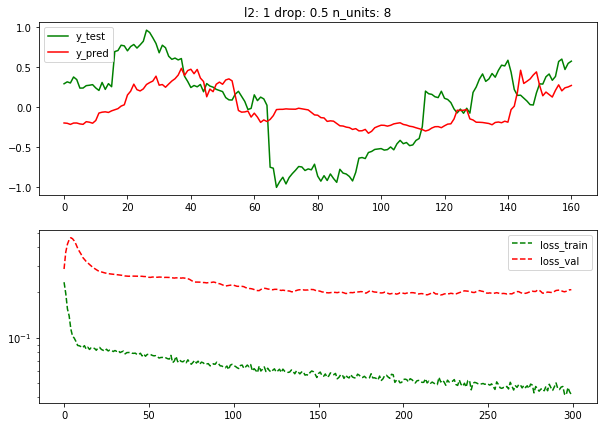

Min val loss:  0.1925843507051468
.

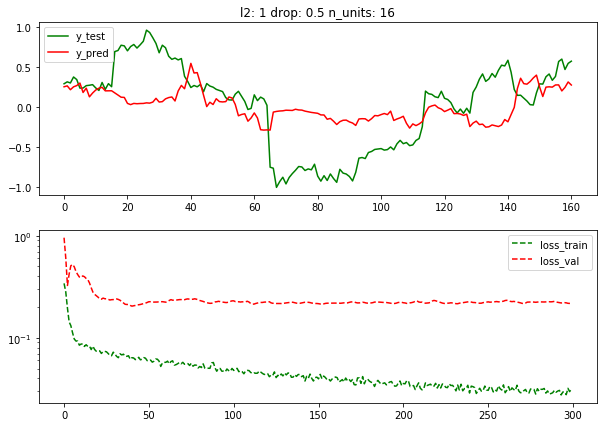

Min val loss:  0.20423857867717743
.

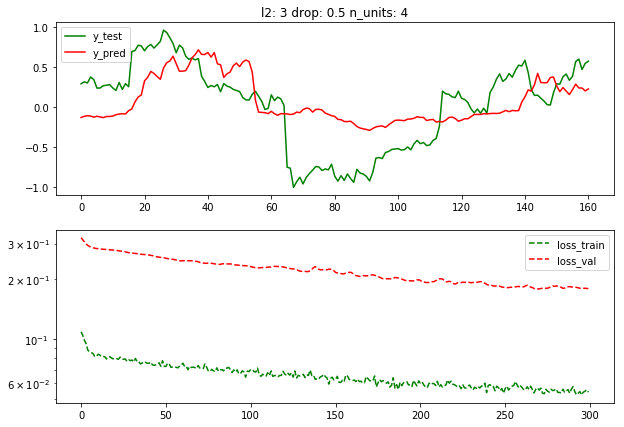

Min val loss:  0.1777467280626297
.

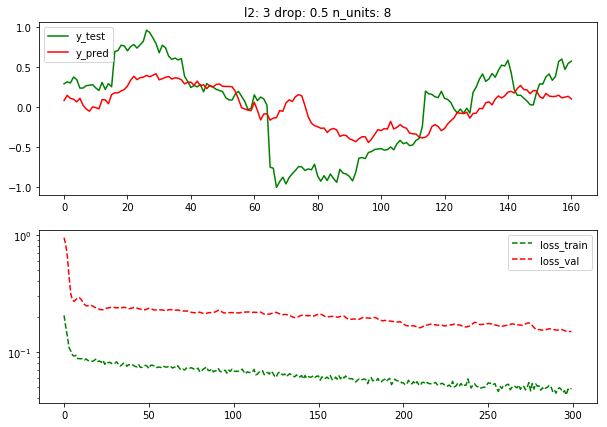

Min val loss:  0.14875417947769165
.

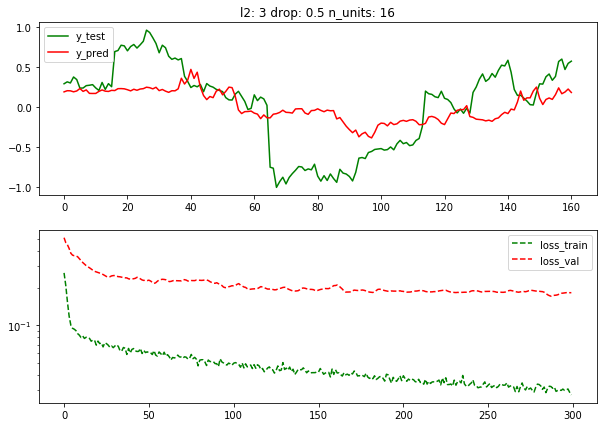

Min val loss:  0.172001913189888
.

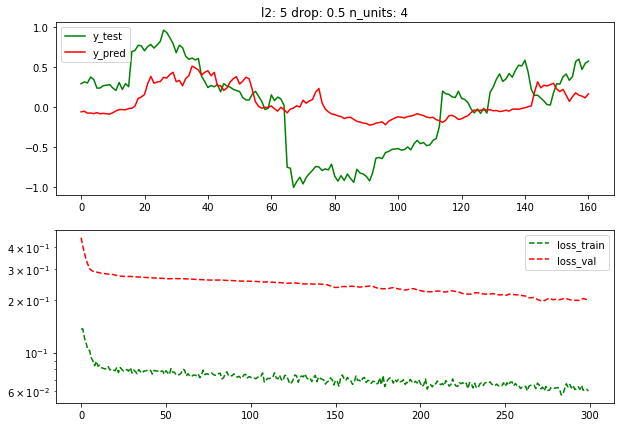

Min val loss:  0.19747962057590485
.

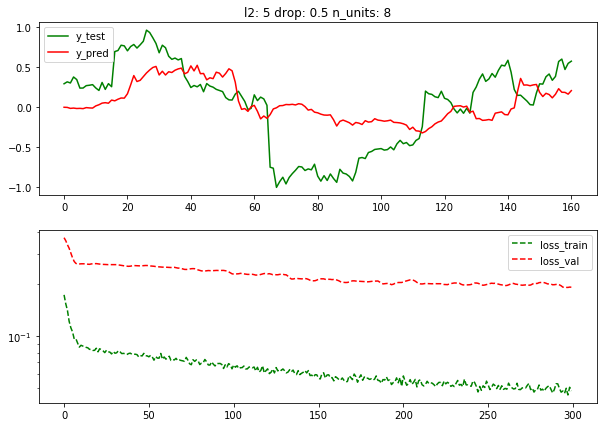

Min val loss:  0.1910022497177124
.

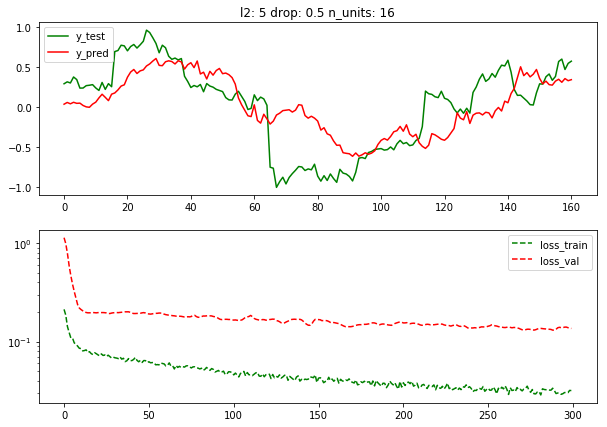

Min val loss:  0.13053089380264282
.

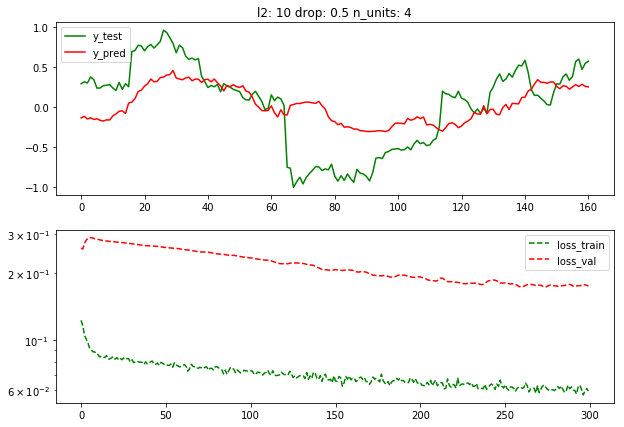

Min val loss:  0.1731831282377243
.

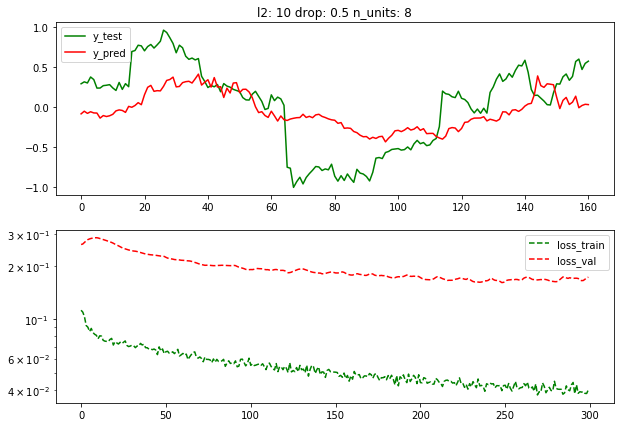

Min val loss:  0.16070762276649475
.

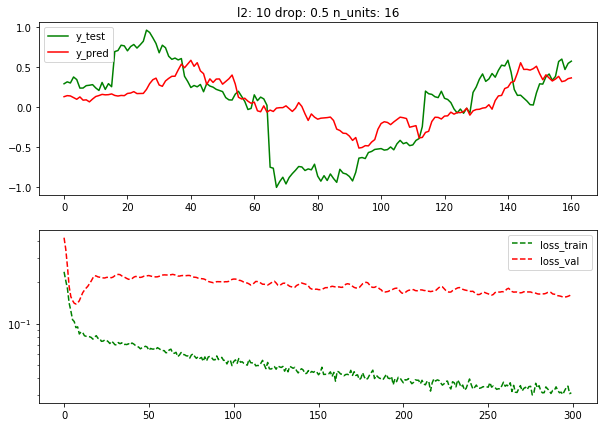

Min val loss:  0.13877516984939575
==== Test ===


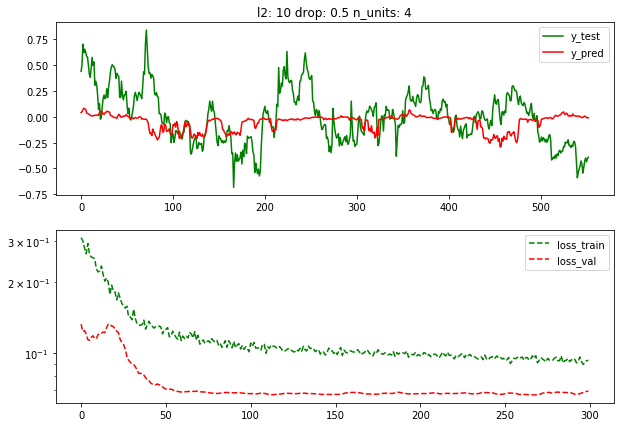

Min val loss:  0.0664659454259907

CSCO
.

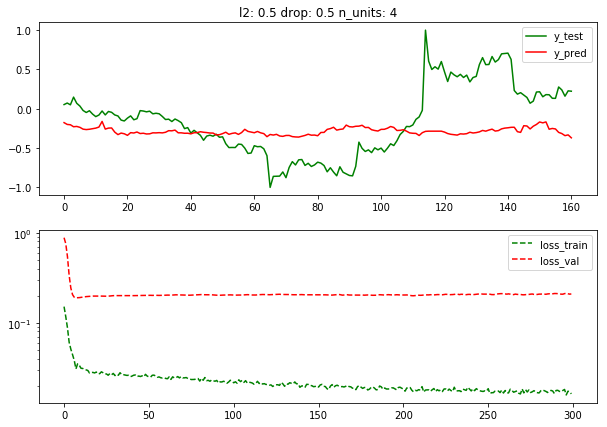

Min val loss:  0.18926434218883514
.

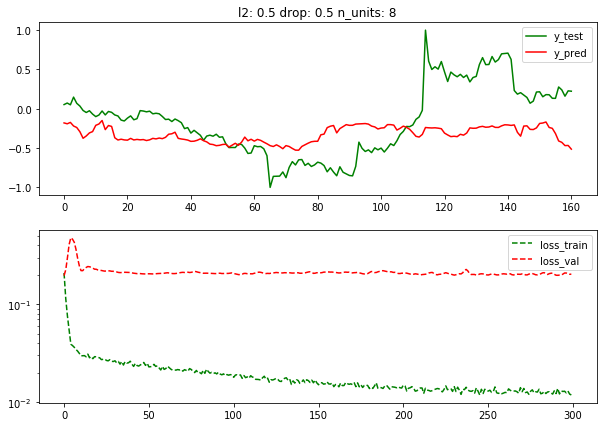

Min val loss:  0.19644491374492645
.

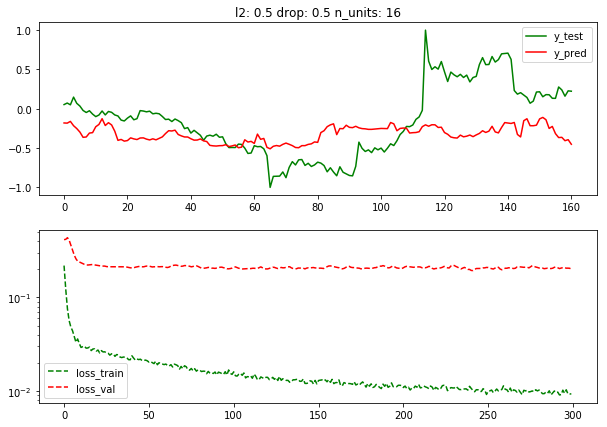

Min val loss:  0.1939908117055893
.

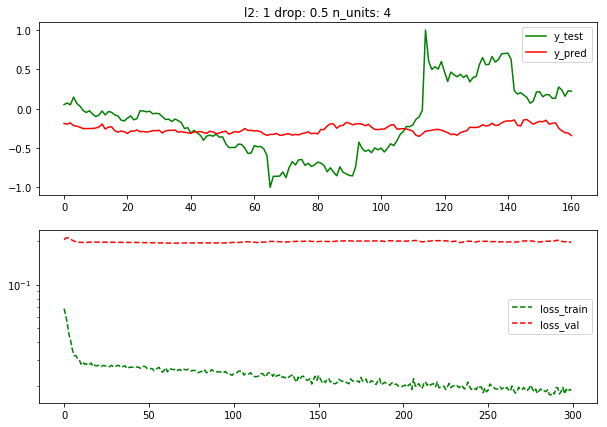

Min val loss:  0.19349347054958344
.

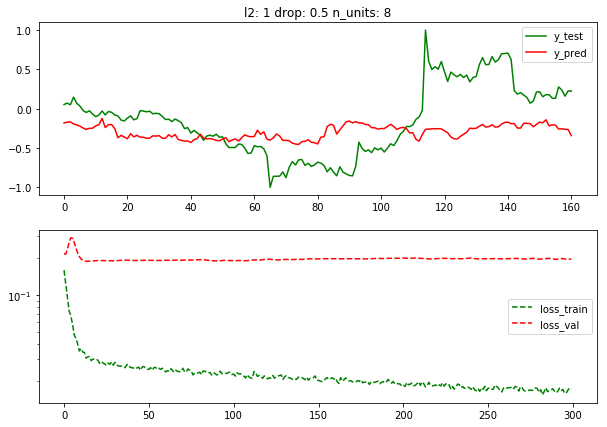

Min val loss:  0.18784265220165253
.

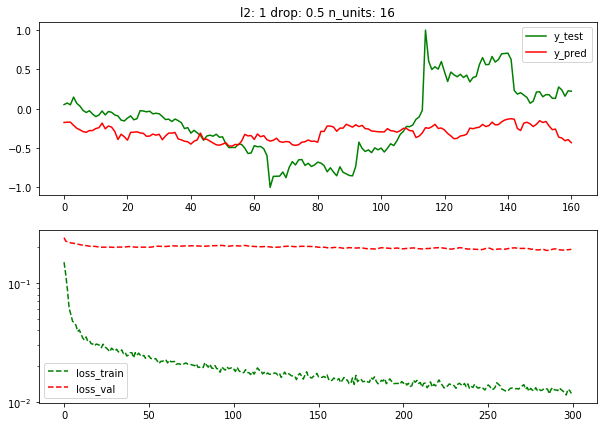

Min val loss:  0.1877494603395462
.

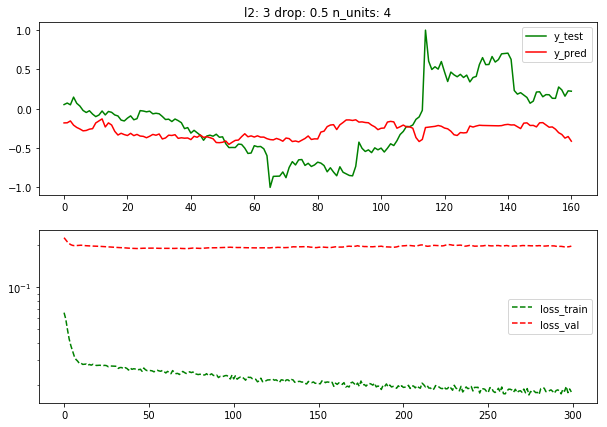

Min val loss:  0.1897108256816864
.

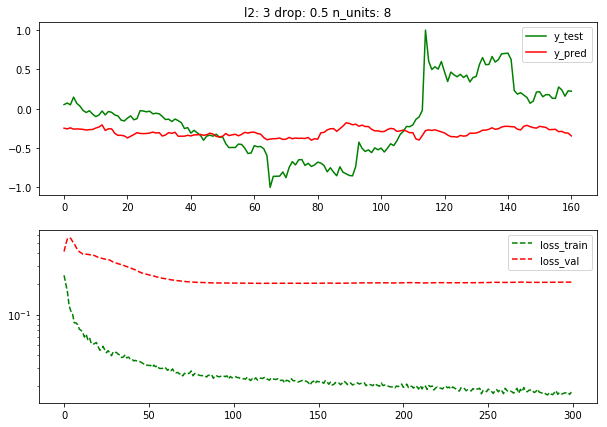

Min val loss:  0.20209074020385742
.

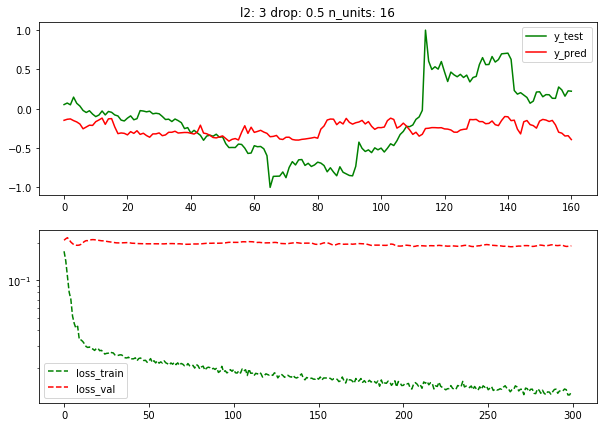

Min val loss:  0.18626680970191956
.

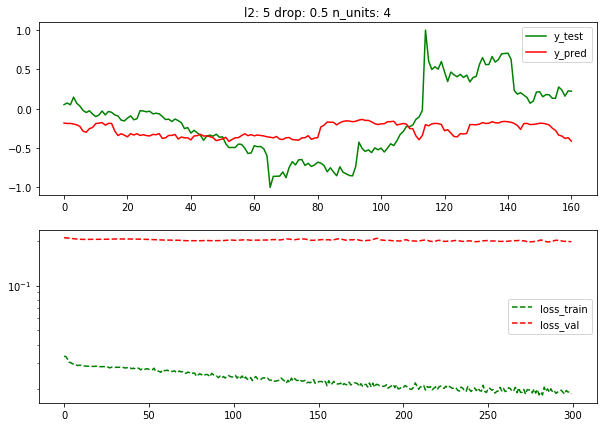

Min val loss:  0.19653591513633728
.

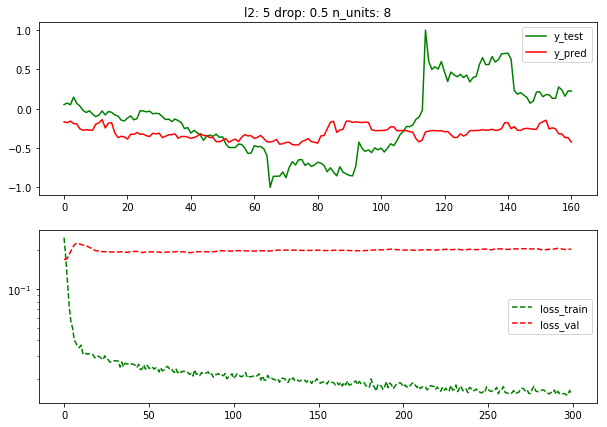

Min val loss:  0.1704372614622116
.

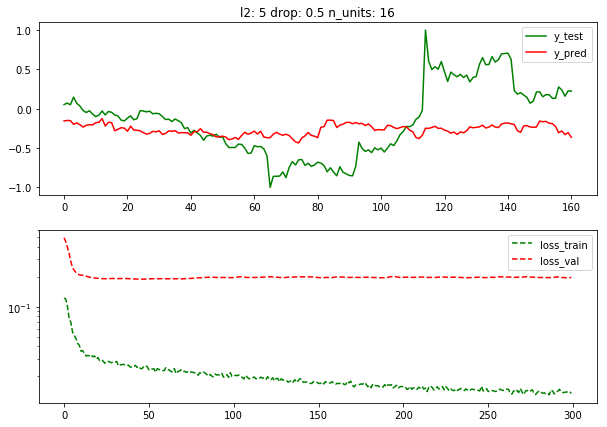

Min val loss:  0.1896907538175583
.

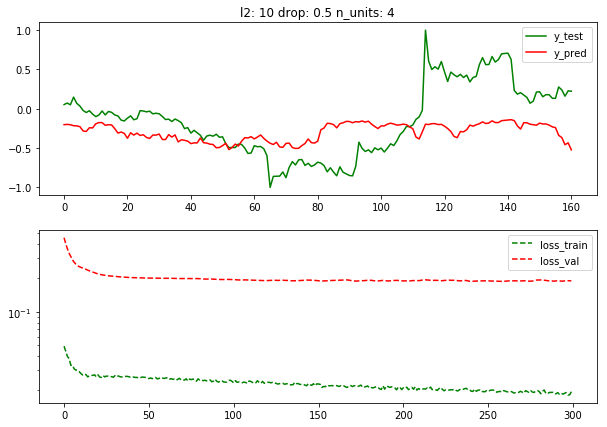

Min val loss:  0.18625764548778534
.

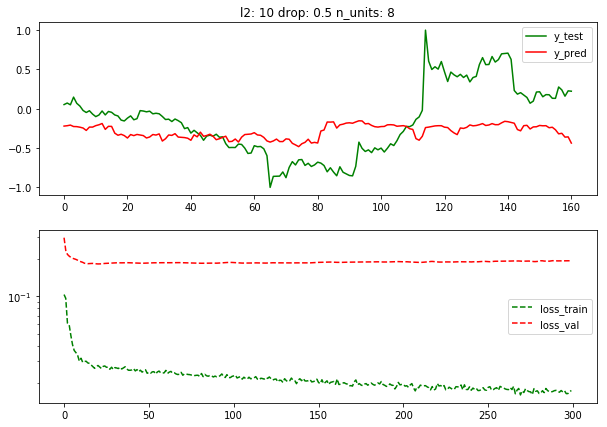

Min val loss:  0.1823294311761856
.

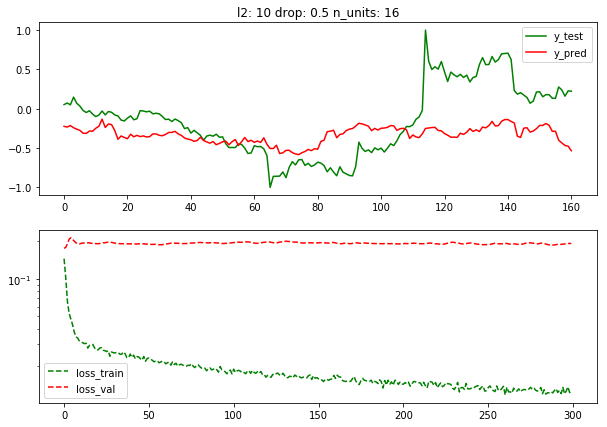

Min val loss:  0.17519064247608185
==== Test ===


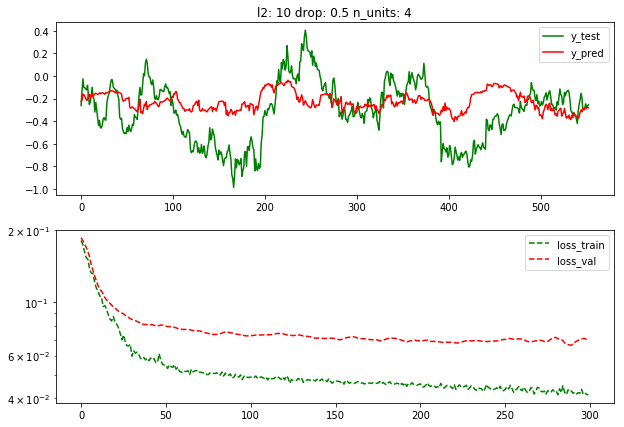

Min val loss:  0.06631642945488042

CMCSA
.

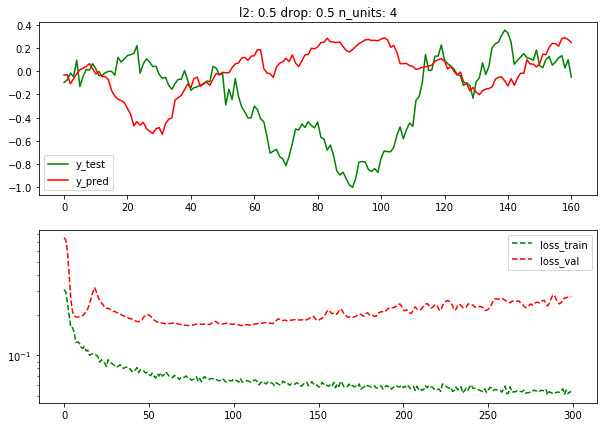

Min val loss:  0.16726326942443848
.

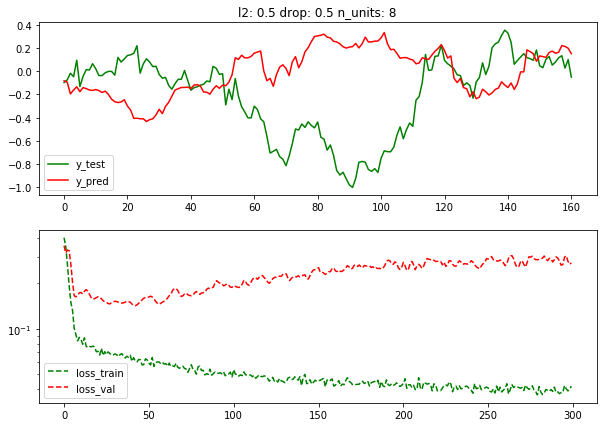

Min val loss:  0.14205248653888702
.

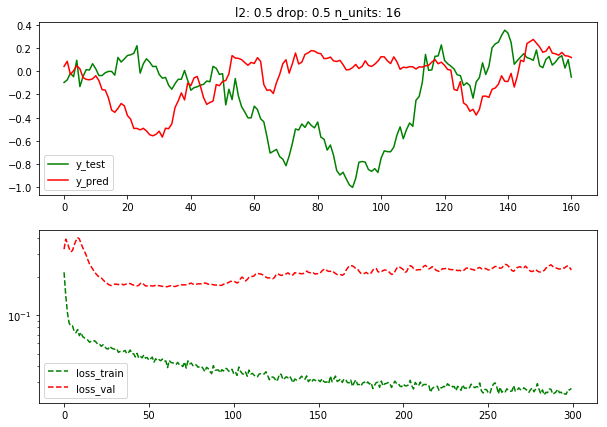

Min val loss:  0.16684111952781677
.

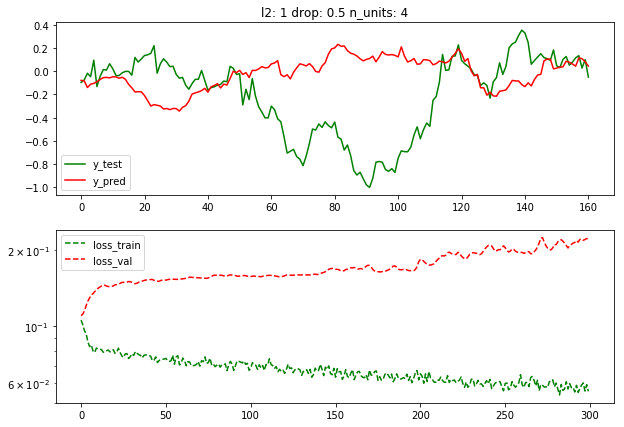

Min val loss:  0.11024252325296402
.

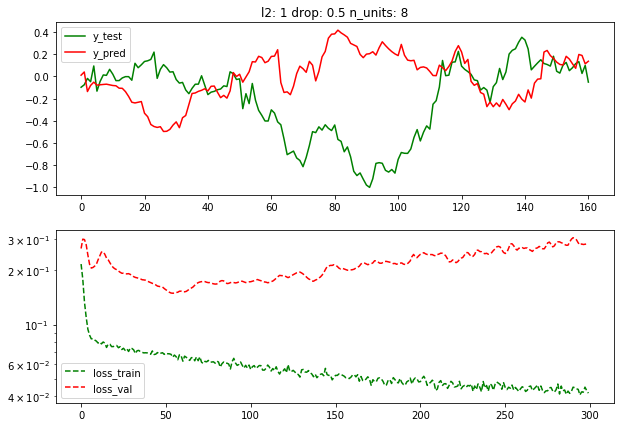

Min val loss:  0.14938367903232574
.

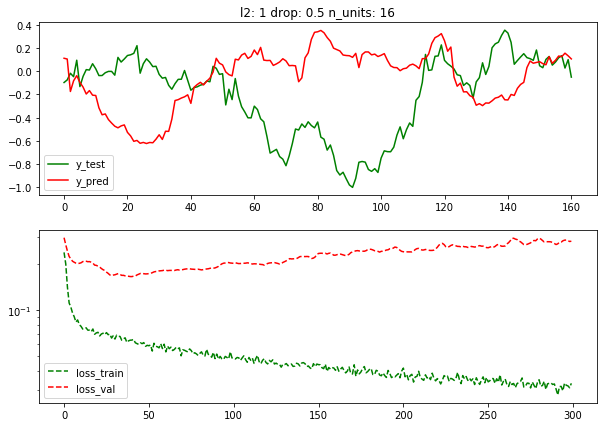

Min val loss:  0.16618719696998596
.

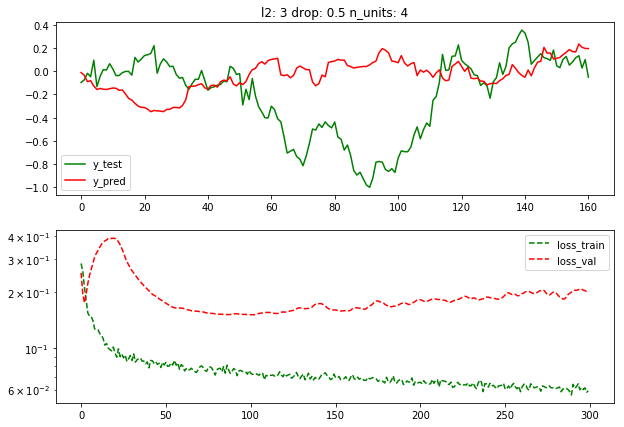

Min val loss:  0.15097415447235107
.

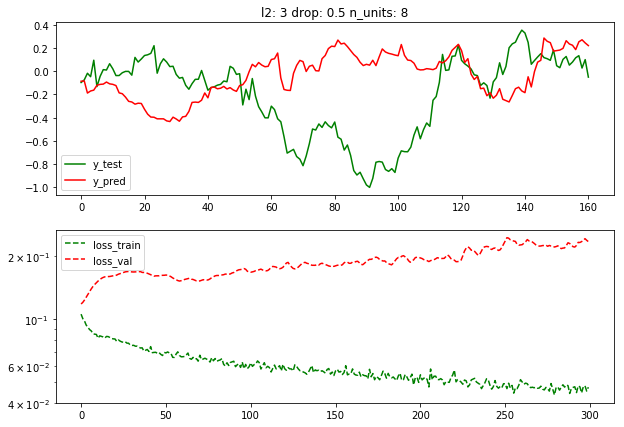

Min val loss:  0.11805600672960281
.

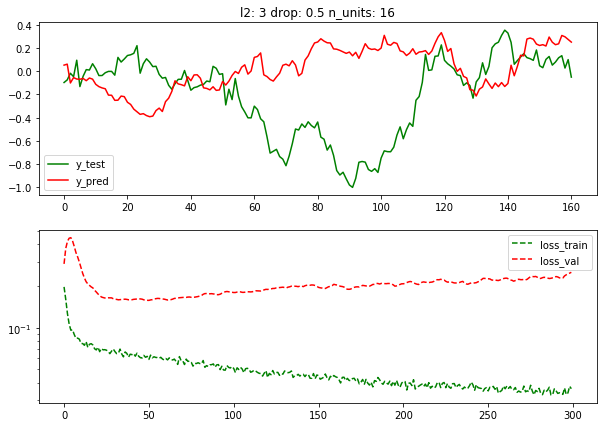

Min val loss:  0.15746009349822998
.

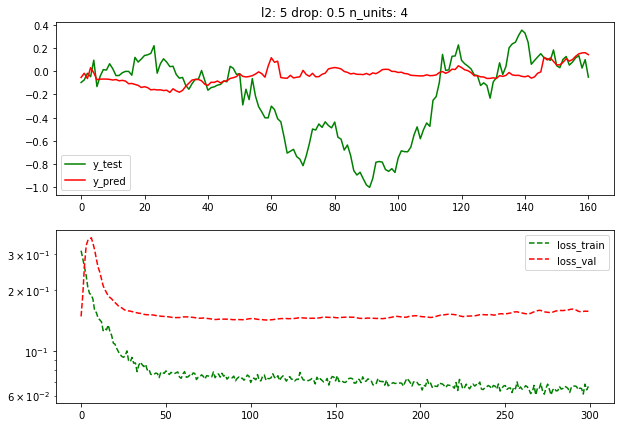

Min val loss:  0.14164073765277863
.

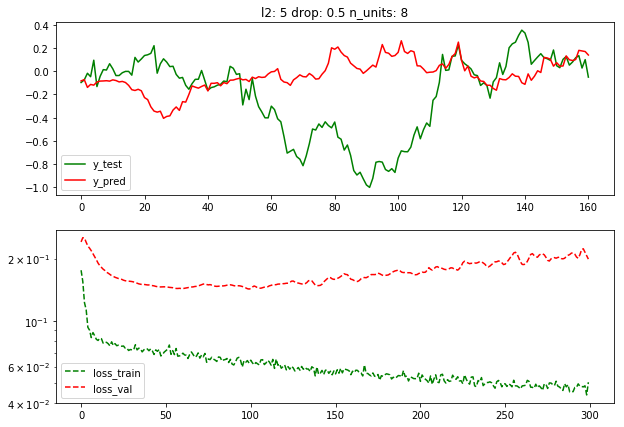

Min val loss:  0.14252051711082458
.

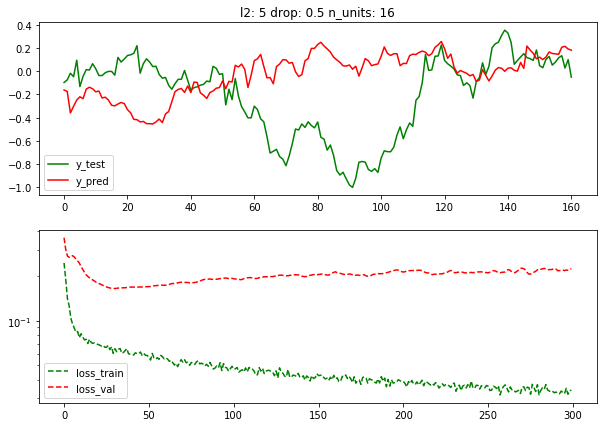

Min val loss:  0.16440723836421967
.

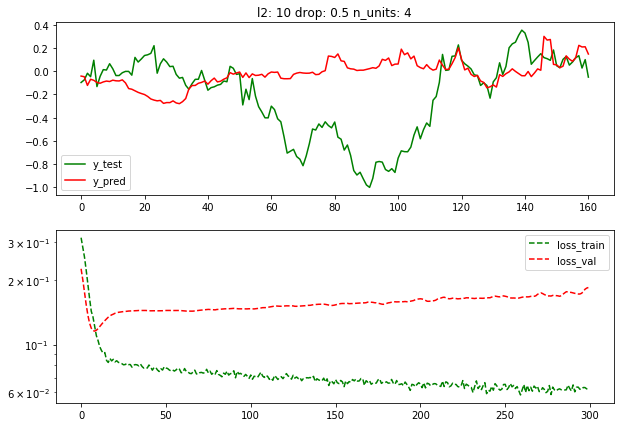

Min val loss:  0.11554490774869919
.

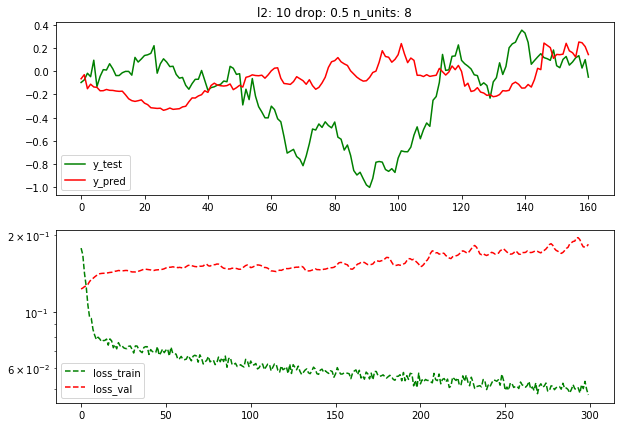

Min val loss:  0.12293646484613419
.

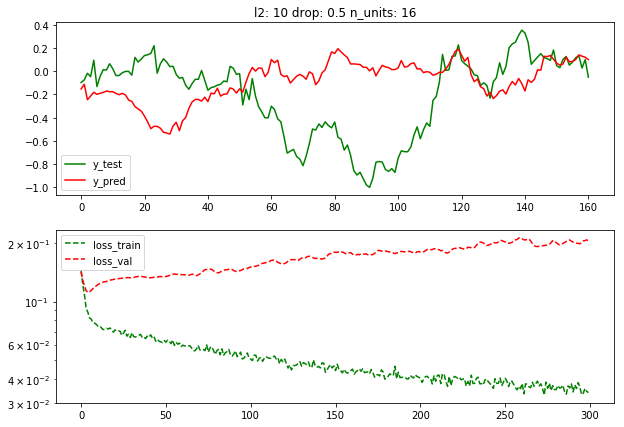

Min val loss:  0.11135842651128769
==== Test ===


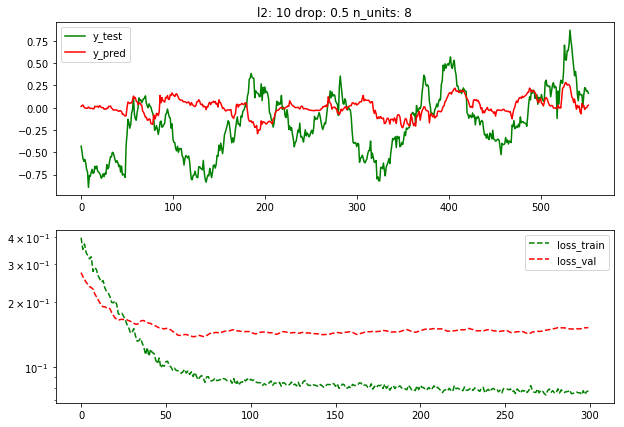

Min val loss:  0.13809334113520266

NVDA
.

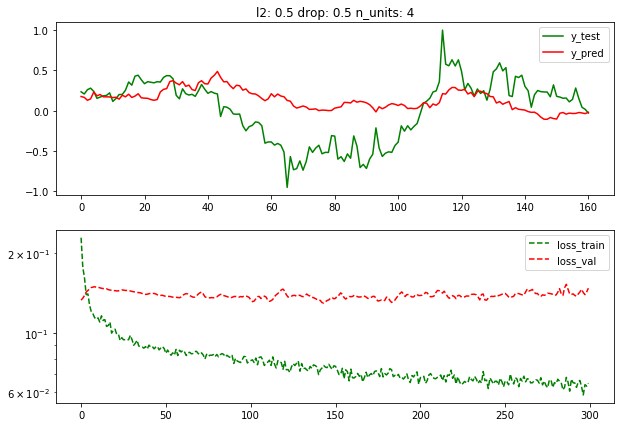

Min val loss:  0.1294192671775818
.

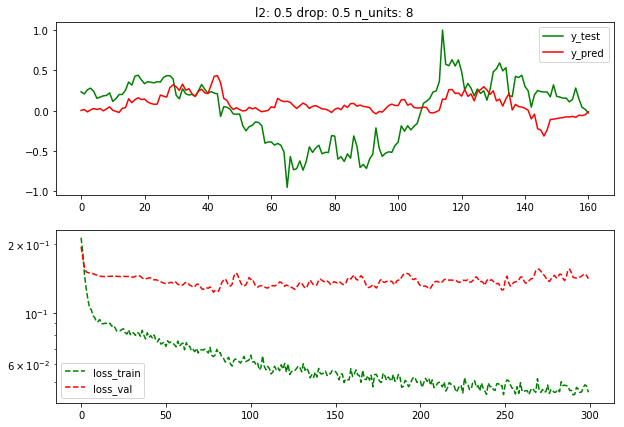

Min val loss:  0.12296655029058456
.

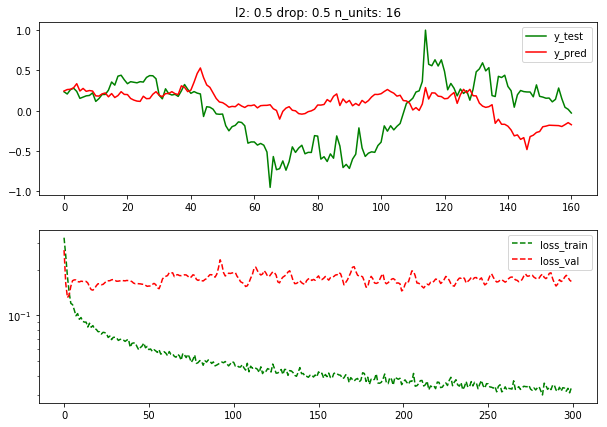

Min val loss:  0.131188303232193
.

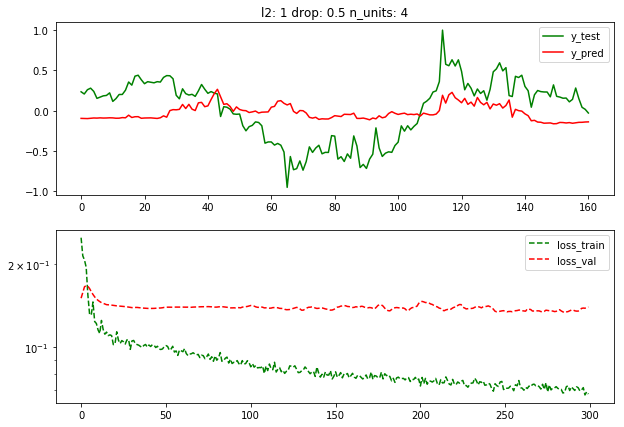

Min val loss:  0.133731871843338
.

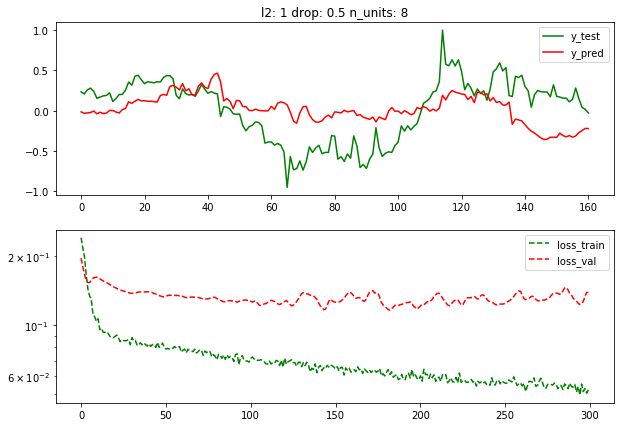

Min val loss:  0.11594100296497345
.

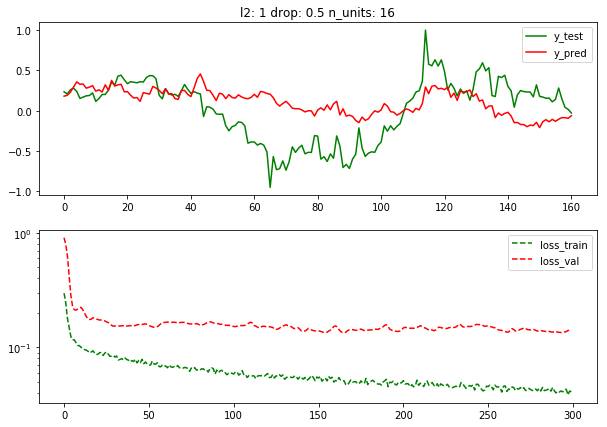

Min val loss:  0.13416153192520142
.

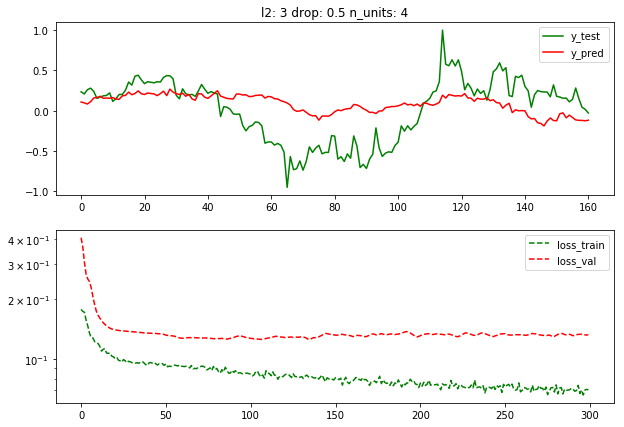

Min val loss:  0.12579993903636932
.

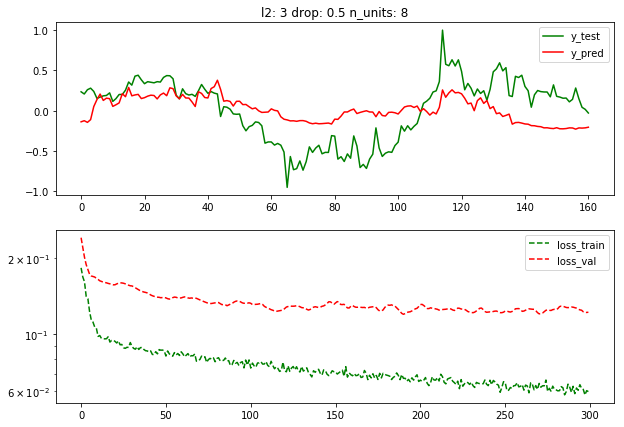

Min val loss:  0.11992276459932327
.

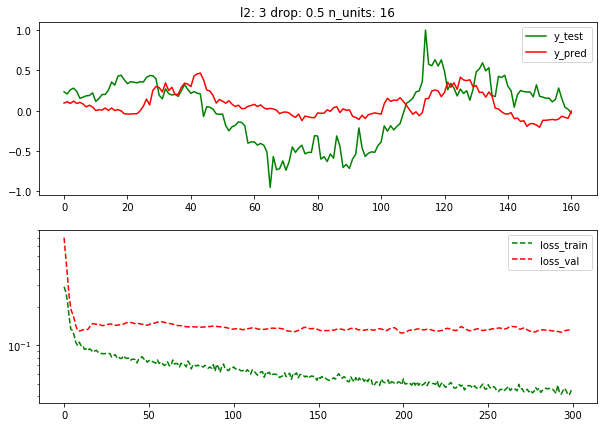

Min val loss:  0.12456735223531723
.

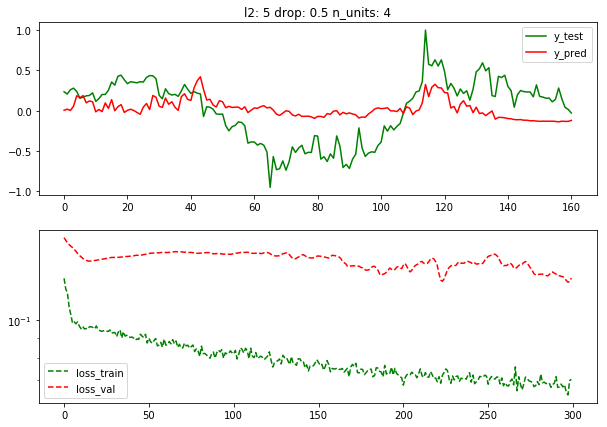

Min val loss:  0.12561020255088806
.

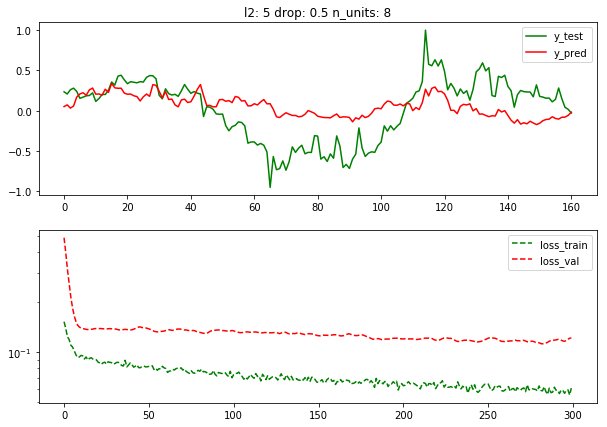

Min val loss:  0.1121235266327858
.

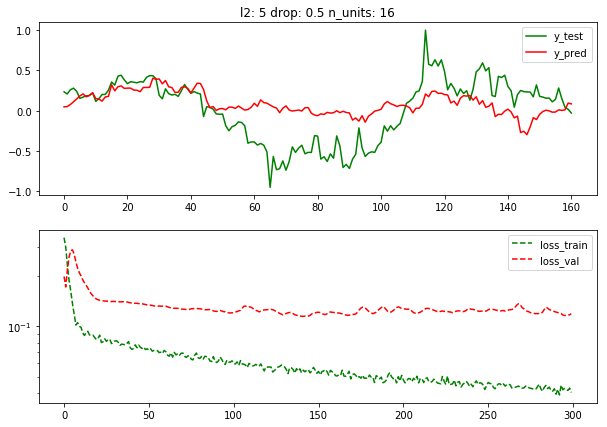

Min val loss:  0.11492148786783218
.

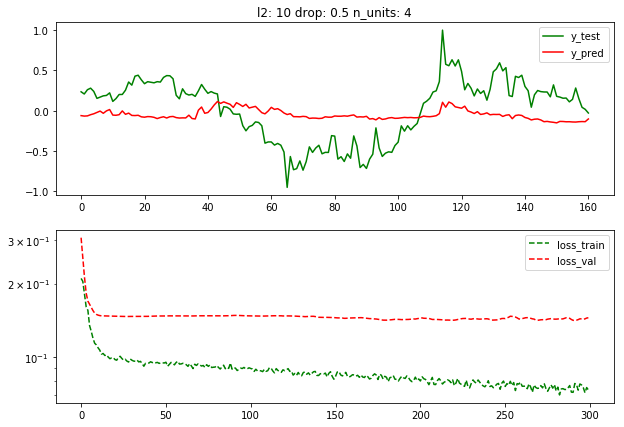

Min val loss:  0.14139387011528015
.

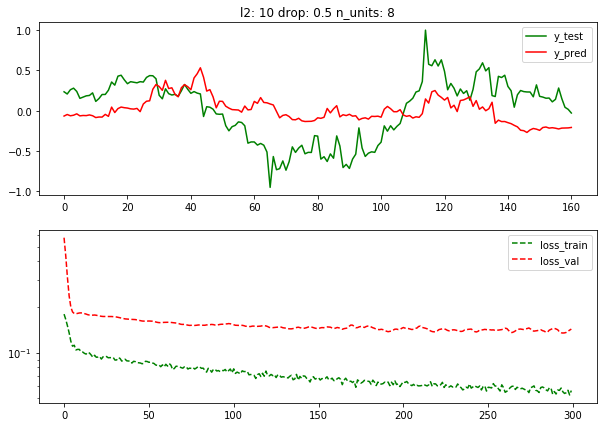

Min val loss:  0.13462263345718384
.

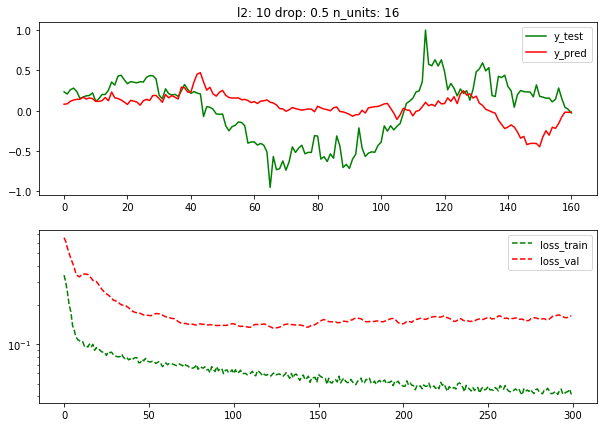

Min val loss:  0.13323314487934113
==== Test ===


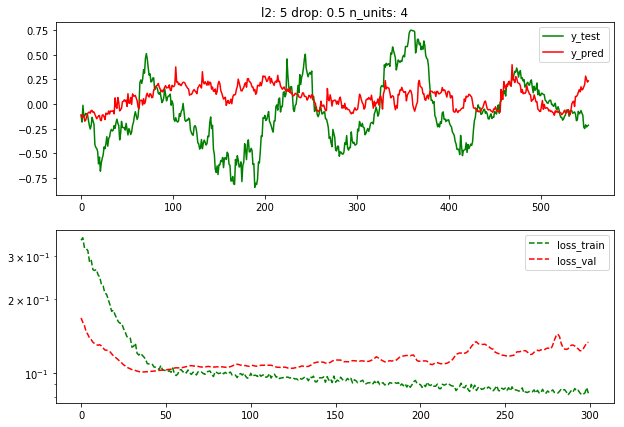

Min val loss:  0.10124078446200915

NFLX
.

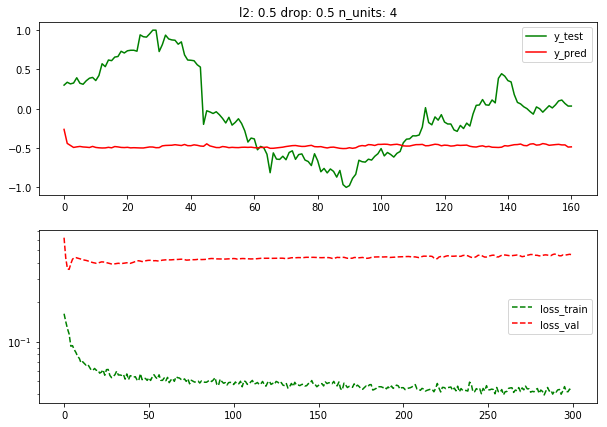

Min val loss:  0.35588887333869934
.

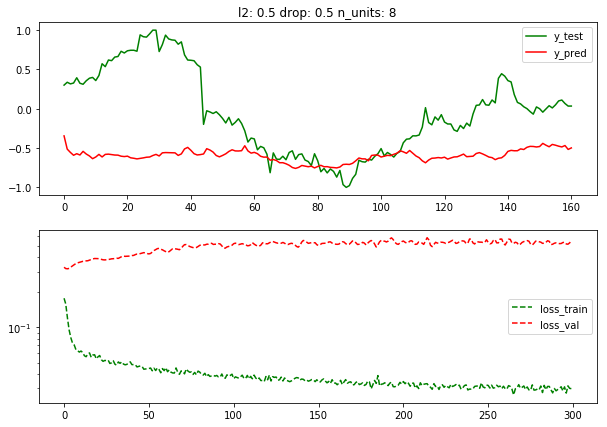

Min val loss:  0.31723883748054504
.

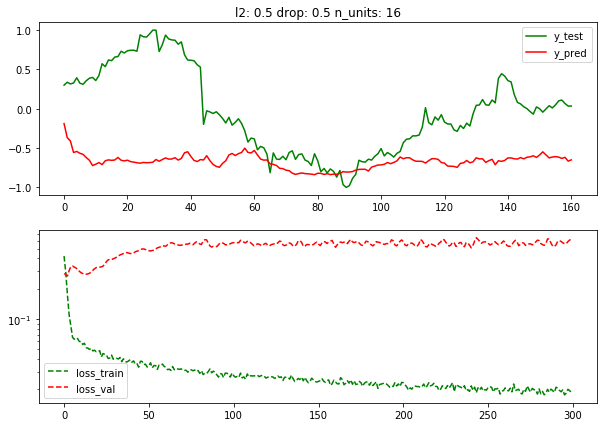

Min val loss:  0.26689833402633667
.

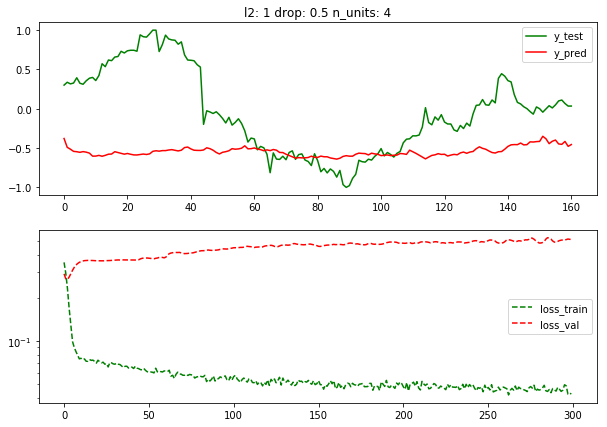

Min val loss:  0.26825961470603943
.

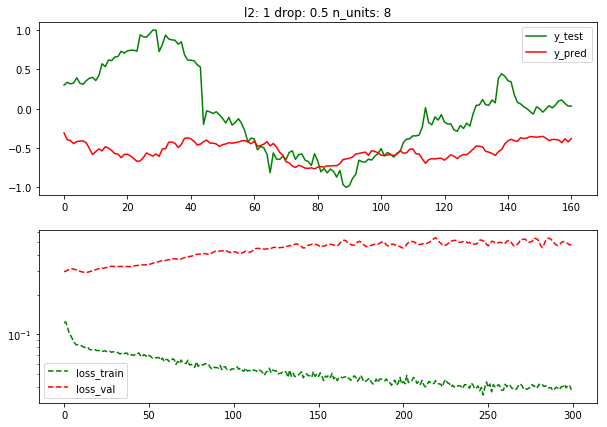

Min val loss:  0.2945918142795563
.

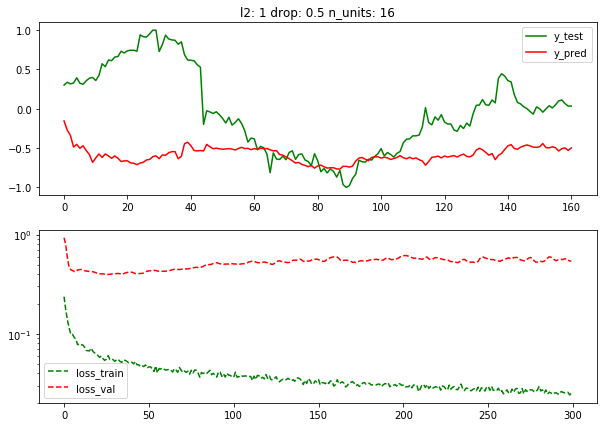

Min val loss:  0.3948703408241272
.

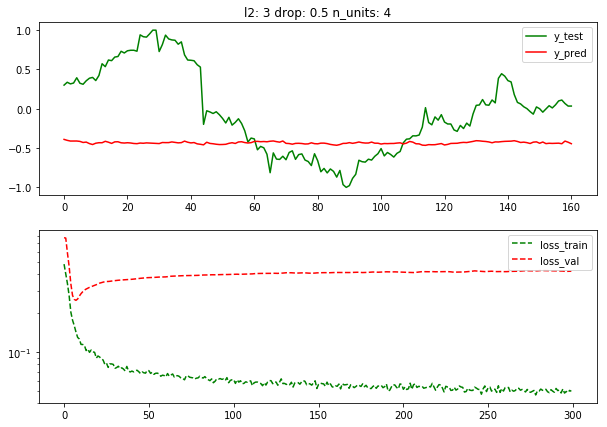

Min val loss:  0.2517920732498169
.

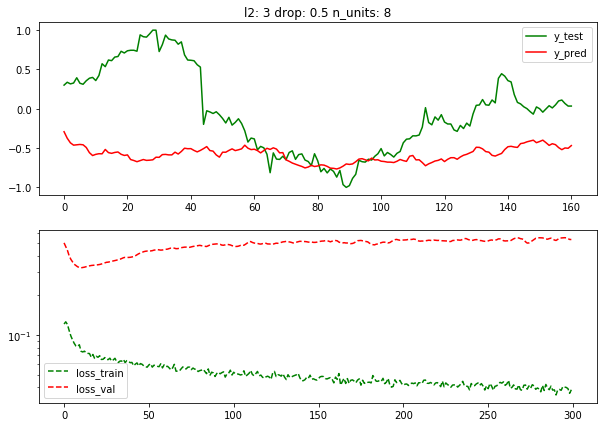

Min val loss:  0.3246774971485138
.

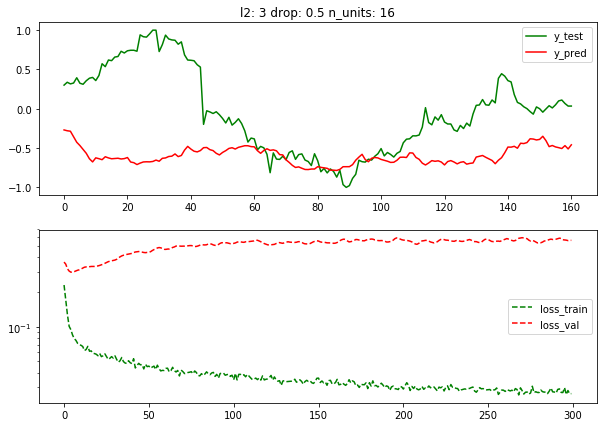

Min val loss:  0.29777413606643677
.

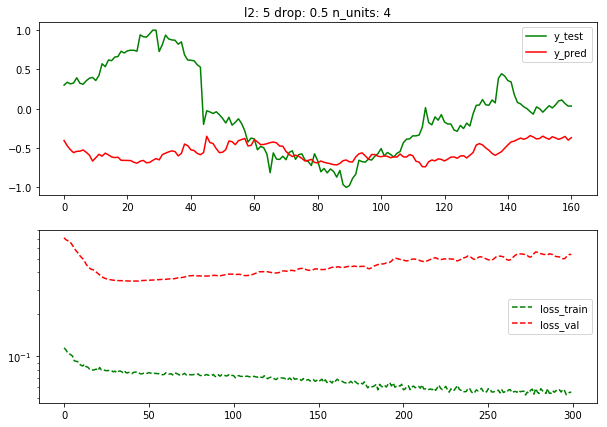

Min val loss:  0.3459613025188446
.

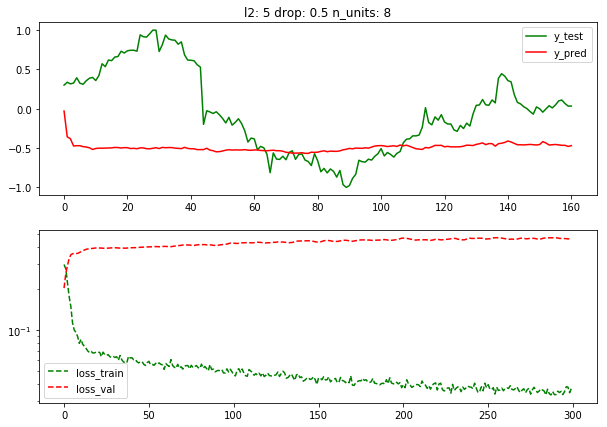

Min val loss:  0.20143841207027435
.

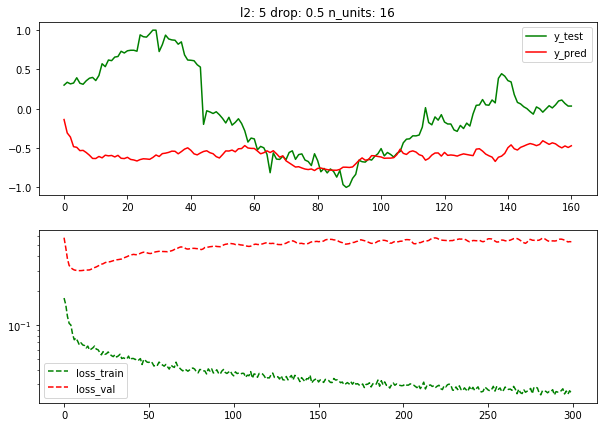

Min val loss:  0.2991858422756195
.

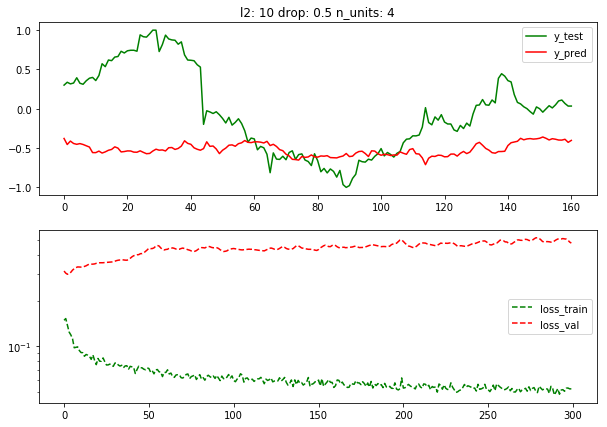

Min val loss:  0.2985336184501648
.

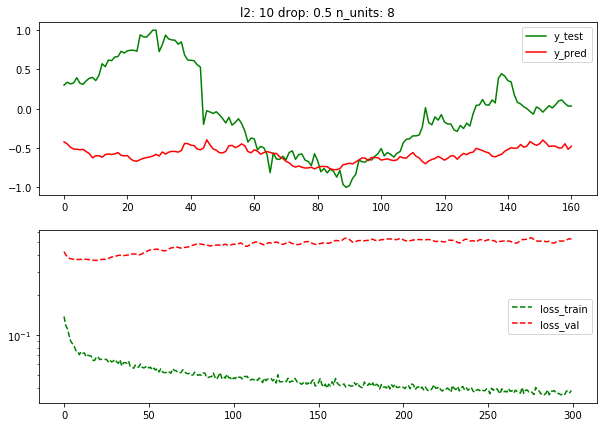

Min val loss:  0.36542344093322754
.

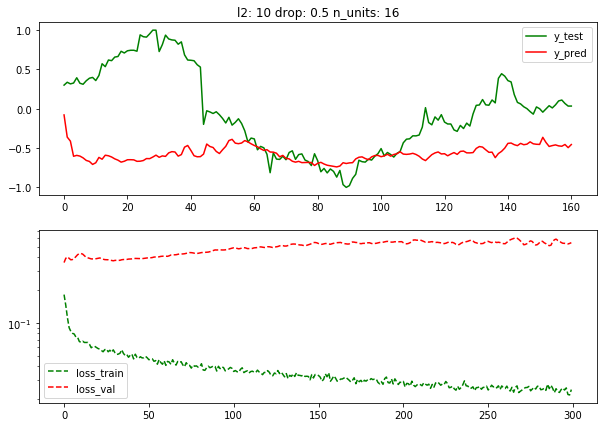

Min val loss:  0.35652297735214233
==== Test ===


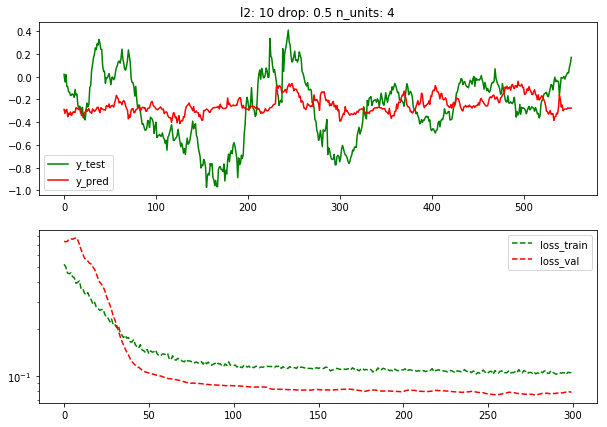

Min val loss:  0.07552021752645482


In [8]:
for (init, finish) in TREND_WINDOWs:
    print('\n\n\n====================  trend: ',init,' ',finish, ' ==================== \n\n')
    for ticker in tickers:
        print('\n'+ticker)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        (best_l2,best_drop,best_n_units) = cv(x_tv,y_tv)
        #nn_model = buildNN(l2_regularizer=best_l2,n_units=best_n_units,dropout=best_drop)
        nn_model = buildNN2(n_expected_active_units=best_n_units, dropout = best_drop, max_norm_val = best_l2)
        
        history = nn_model.fit(x_tv, y_tv, epochs = 300,batch_size =256, verbose=0, validation_data=(x_test, y_test),shuffle=True)
        y_pred = nn_model.predict(x_test, batch_size=256, verbose=0)
        print('==== Test ===')
        plot_hystory(history,y_pred,y_test,best_l2,best_drop,best_n_units)  
        